# Capstone Project 01 - AD Campaign Recommender
## Praveen Selvaraj
### praveenselvaraj.ps@gmail.com
### MS in Data Science
### University of Arizona (upGrad)

# Install required libraries through requirements.txt file

In [2]:
!pip install -r requirements.txt

  Using cached xgboost-2.0.2-py3-none-win_amd64.whl (99.8 MB)


# Import of Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix,hstack
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,confusion_matrix,precision_score,recall_score,roc_auc_score,classification_report,confusion_matrix,accuracy_score,f1_score,log_loss
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
import category_encoders as ce
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

warnings.filterwarnings("ignore")
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib



# Read Data

In [5]:
dfAppEvents = pd.read_csv("https://uoacapstone.s3.amazonaws.com/app_events.csv")

dfTrainEvents = pd.read_csv("https://uoacapstone.s3.amazonaws.com/train_event_data.csv")

dfMetaAppEvents = pd.read_csv("https://uoacapstone.s3.amazonaws.com/app_events_meta_data.csv",quoting=csv.QUOTE_NONE)

dfMobileBrandTrain = pd.read_csv("https://uoacapstone.s3.amazonaws.com/train_mobile_brand.csv")

## Basic Stats on the Datasets

In [6]:
dfMetaAppEvents.head()

,app_id,label_id,category
0,app_id,label_id,category
1,7324884708820027918,251,Finance
2,-4494216993218550286,251,Finance
3,6058196446775239644,406,unknown
4,6058196446775239644,407,DS_P2P net loan


In [7]:
dfAppEvents.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [8]:
dfTrainEvents.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79


In [9]:
dfMobileBrandTrain.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


## Renaming columns in each DataFrame

In [11]:
dfMetaAppEvents.columns = ["AppID", "LabelID", "Category"]

dfAppEvents.columns = ["EventID", "AppID", "IsInstalled", "IsActive"]

dfTrainEvents.columns = ["DeviceID", "Gender", "Age", "GroupTrain", "EventID", "DateTimestamp", "Latitude", "Longitude"]

dfMobileBrandTrain.columns = ["DeviceID", "Gender", "Age", "GroupTrain", "MobilePhoneBrand", "DeviceModel"]

In [12]:
dfMetaAppEvents.columns, dfAppEvents.columns, dfTrainEvents.columns, dfMobileBrandTrain.columns

(Index(['AppID', 'LabelID', 'Category'], dtype='object'),
 Index(['EventID', 'AppID', 'IsInstalled', 'IsActive'], dtype='object'),
 Index(['DeviceID', 'Gender', 'Age', 'GroupTrain', 'EventID', 'DateTimestamp',
        'Latitude', 'Longitude'],
       dtype='object'),
 Index(['DeviceID', 'Gender', 'Age', 'GroupTrain', 'MobilePhoneBrand',
        'DeviceModel'],
       dtype='object'))

## Cleaning the Data
Removing Duplicates, Dealing with Null Values and other junk data

### MetaAppEvents

In [13]:
dfMetaAppEvents = dfMetaAppEvents.iloc[1:,:].reset_index(drop=True)
dfMetaAppEvents.head(3)

,AppID,LabelID,Category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown


In [14]:
dfMetaAppEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AppID     459943 non-null  object
 1   LabelID   459943 non-null  object
 2   Category  459943 non-null  object
dtypes: object(3)
memory usage: 10.5+ MB


In [15]:
dfMetaAppEvents.AppID = dfMetaAppEvents.AppID.astype("int64")

dfMetaAppEvents.LabelID = dfMetaAppEvents.LabelID.astype("int64")

In [16]:
dfMetaAppEvents.Category = dfMetaAppEvents.Category.str.upper()

### MobileBrandTrain

In [17]:
dfMobileBrandTrain.head()

,DeviceID,Gender,Age,GroupTrain,MobilePhoneBrand,DeviceModel
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


#### Dealing with Junk Data such as in the 1st row in column DeviceModel - è£è€€3C

In [18]:
#Function to Clean Gibberish Data
def cleanJunk(str):
    if str.isascii():
        return str
        
    else:
        a="".join(list(map(lambda x:x if x.isascii() else "",str)))
        return a
        
dfMobileBrandTrain["DeviceModel"] = dfMobileBrandTrain["DeviceModel"].apply(cleanJunk)
dfMobileBrandTrain.head()

,DeviceID,Gender,Age,GroupTrain,MobilePhoneBrand,DeviceModel
0,-7548291590301750000,M,33,M32+,Huawei,3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


In [19]:
dfMobileBrandTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DeviceID          74840 non-null  int64 
 1   Gender            74840 non-null  object
 2   Age               74840 non-null  int64 
 3   GroupTrain        74840 non-null  object
 4   MobilePhoneBrand  74840 non-null  object
 5   DeviceModel       74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


##### Number of Unique Values for each column in dfMobileBrandTrain

In [20]:
dfMobileBrandTrain.Gender.nunique(), dfMobileBrandTrain.Age.nunique(), dfMobileBrandTrain.GroupTrain.nunique(), dfMobileBrandTrain.MobilePhoneBrand.nunique(), dfMobileBrandTrain.DeviceModel.nunique()

(2, 85, 6, 97, 1385)

In [21]:
dfMobileBrandTrain.MobilePhoneBrand = dfMobileBrandTrain.MobilePhoneBrand.str.upper()

dfMobileBrandTrain.DeviceModel = dfMobileBrandTrain.DeviceModel.str.upper()

dfMobileBrandTrain.duplicated().value_counts(dropna=False)

False    74646
True       194
dtype: int64

In [22]:
print(dfMobileBrandTrain.shape)
dfMobileBrandTrain.drop_duplicates(subset=None, keep="first", inplace=True)
print(dfMobileBrandTrain.shape)

(74840, 6)
(74646, 6)


In [23]:
dfMobileBrandTrain.duplicated().value_counts(dropna=False)

False    74646
dtype: int64

### AppEvents Data

In [24]:
dfAppEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   EventID      int64
 1   AppID        int64
 2   IsInstalled  int64
 3   IsActive     int64
dtypes: int64(4)
memory usage: 991.0 MB


In [25]:
dfAppEvents.nunique()

EventID        1488096
AppID            19237
IsInstalled          1
IsActive             2
dtype: int64

##### All Rows seem to have 1 value for column - IsInstalled. Will drop this column

In [26]:
dfAppEvents = dfAppEvents[["EventID", "AppID", "IsActive"]]
dfAppEvents.nunique()

EventID     1488096
AppID         19237
IsActive          2
dtype: int64

In [27]:
dfAppEvents.duplicated().value_counts(dropna=False)

False    32473067
dtype: int64

### TrainEvents Data

In [28]:
dfTrainEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   DeviceID       1266933 non-null  int64  
 1   Gender         1266933 non-null  object 
 2   Age            1266933 non-null  int64  
 3   GroupTrain     1266933 non-null  object 
 4   EventID        1215598 non-null  float64
 5   DateTimestamp  1215598 non-null  object 
 6   Latitude       1215598 non-null  float64
 7   Longitude      1215598 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 77.3+ MB


##### Format the type for DateTimestamp

In [29]:
dfTrainEvents["DateTimestamp"]=pd.to_datetime(dfTrainEvents["DateTimestamp"])

In [30]:
dfTrainEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   DeviceID       1266933 non-null  int64         
 1   Gender         1266933 non-null  object        
 2   Age            1266933 non-null  int64         
 3   GroupTrain     1266933 non-null  object        
 4   EventID        1215598 non-null  float64       
 5   DateTimestamp  1215598 non-null  datetime64[ns]
 6   Latitude       1215598 non-null  float64       
 7   Longitude      1215598 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 77.3+ MB


##### Create new features from DateTimestamp Column, such as Hour, WeekDay, DayName and WeekNum

In [31]:
dfTrainEvents["Hour"] = dfTrainEvents.DateTimestamp.dt.hour

dfTrainEvents["WeekDay"] = dfTrainEvents.DateTimestamp.dt.day_of_week

dfTrainEvents["DayName"] = dfTrainEvents.DateTimestamp.dt.day_name()

dfTrainEvents["WeekNum"] = dfTrainEvents.DateTimestamp.dt.weekofyear

In [32]:
dfTrainEvents["Hour"].value_counts(), dfTrainEvents["WeekDay"].value_counts(), dfTrainEvents["DayName"].value_counts(), dfTrainEvents["WeekNum"].value_counts()

(10.0    68578
 21.0    67498
 20.0    65099
 11.0    62920
 12.0    62584
 9.0     62226
 22.0    61978
 19.0    61947
 8.0     59032
 13.0    58304
 17.0    58200
 18.0    57610
 16.0    57002
 14.0    56324
 7.0     55583
 15.0    55224
 23.0    51508
 0.0     44864
 6.0     43970
 1.0     27090
 5.0     24536
 2.0     20248
 3.0     16991
 4.0     16282
 Name: Hour, dtype: int64,
 1.0    180296
 3.0    180041
 2.0    178371
 4.0    176657
 0.0    169381
 5.0    166835
 6.0    164017
 Name: WeekDay, dtype: int64,
 Tuesday      180296
 Thursday     180041
 Wednesday    178371
 Friday       176657
 Monday       169381
 Saturday     166835
 Sunday       164017
 Name: DayName, dtype: int64,
 18.0    1051204
 17.0     164394
 Name: WeekNum, dtype: int64)

In [33]:
print("Total Number of Records without Events ", "\t- ", dfTrainEvents.EventID.isnull().sum())

print("Total Number of Records with Events ", "\t\t- ", dfTrainEvents.EventID[~(dfTrainEvents.EventID.isnull())].shape[0])

print("Total Number of Records ", "\t\t\t- ", dfTrainEvents.shape[0])

print("Percent of Devices without Events ", "\t\t- ", round(100*dfTrainEvents.EventID.isnull().sum()/dfTrainEvents.EventID[~(dfTrainEvents.EventID.isnull())].shape[0], 2), "%")

Total Number of Records without Events  	-  51335
Total Number of Records with Events  		-  1215598
Total Number of Records  			-  1266933
Percent of Devices without Events  		-  4.22 %


##### Create a DataFrame where the EventIDs are not null

In [34]:
dfTrainEventsWithEventData = dfTrainEvents[~(dfTrainEvents.EventID.isnull())]

dfTrainEventsWithEventData.shape[0]

1215598

In [35]:
dfTrainEventsWithEventData["Coordinates"] = dfTrainEventsWithEventData[["Latitude", "Longitude"]].apply(lambda x: (x["Latitude"], x["Longitude"]), axis = 1)

dfTrainEventsWithEventData.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,15.0,1.0,Tuesday,18.0,"(33.98, 116.79)"
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,6.0,1.0,Tuesday,18.0,"(33.98, 116.79)"
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,3.0,2.0,Wednesday,18.0,"(33.98, 116.79)"
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,2.0,2.0,Wednesday,18.0,"(33.98, 116.79)"
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,15.0,1.0,Tuesday,18.0,"(33.98, 116.79)"


In [36]:
dfTrainEventsWithEventData.EventID = dfTrainEventsWithEventData.EventID.astype("int64")

dfTrainEventsWithEventData.Hour = dfTrainEventsWithEventData.Hour.astype("int64")

dfTrainEventsWithEventData.WeekDay = dfTrainEventsWithEventData.WeekDay.astype("int64")

dfTrainEventsWithEventData.WeekNum = dfTrainEventsWithEventData.WeekNum.astype("int64")

dfTrainEventsWithEventData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215598 entries, 0 to 1251632
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   DeviceID       1215598 non-null  int64         
 1   Gender         1215598 non-null  object        
 2   Age            1215598 non-null  int64         
 3   GroupTrain     1215598 non-null  object        
 4   EventID        1215598 non-null  int64         
 5   DateTimestamp  1215598 non-null  datetime64[ns]
 6   Latitude       1215598 non-null  float64       
 7   Longitude      1215598 non-null  float64       
 8   Hour           1215598 non-null  int64         
 9   WeekDay        1215598 non-null  int64         
 10  DayName        1215598 non-null  object        
 11  WeekNum        1215598 non-null  int64         
 12  Coordinates    1215598 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 129.8+ MB


# EDA and Visualization

#### Usage Through the week

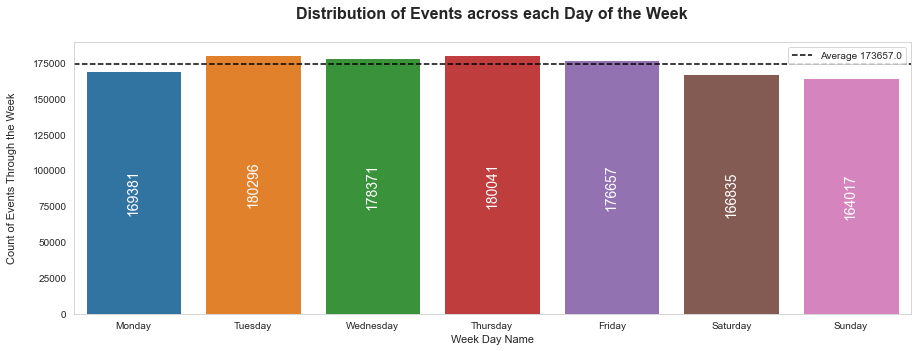

In [37]:
plt.figure(figsize=[15,5])
sns.set_style("whitegrid")

res = sns.countplot(data=dfTrainEventsWithEventData, x="DayName", order=["Monday",
                                                                         "Tuesday", "Wednesday",
                                                                         "Thursday", "Friday",
                                                                         "Saturday", "Sunday"])
plt.grid(visible=False)

plt.title("Distribution of Events across each Day of the Week\n",fontsize=16,loc="center",fontweight="bold")

avg_events_per_day = dfTrainEventsWithEventData.EventID.shape[0]/dfTrainEventsWithEventData.DayName.nunique()
plt.axhline(y=avg_events_per_day, color='black', linestyle="--", label="Average "+str(round(avg_events_per_day,0)))

plt.legend(loc='upper right')

res.set_xlabel(xlabel="Week Day Name",fontsize=11)
res.set_ylabel(ylabel="Count of Events Through the Week\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', color='white', fontsize=14, rotation = 90)

plt.show()

#### Usage Every Hour

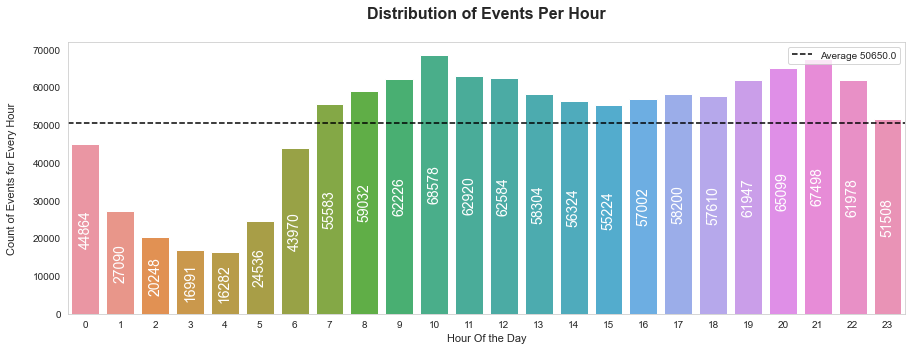

In [38]:
plt.figure(figsize=[15,5])
sns.set_style("whitegrid")

res = sns.countplot(data=dfTrainEventsWithEventData, x="Hour")
plt.grid(visible=False)

plt.title("Distribution of Events Per Hour\n",fontsize=16,loc="center",fontweight="bold")

avg_events_per_hour = dfTrainEventsWithEventData.EventID.shape[0]/dfTrainEventsWithEventData.Hour.nunique()
plt.axhline(y=avg_events_per_hour, color='black', linestyle="--", label="Average "+str(round(avg_events_per_hour,0)))

plt.legend(loc='upper right')

res.set_xlabel(xlabel="Hour Of the Day",fontsize=11)
res.set_ylabel(ylabel="Count of Events for Every Hour\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', color='white', fontsize=14, rotation = 90)

plt.show()

#### Usage Every Hour for each Gender

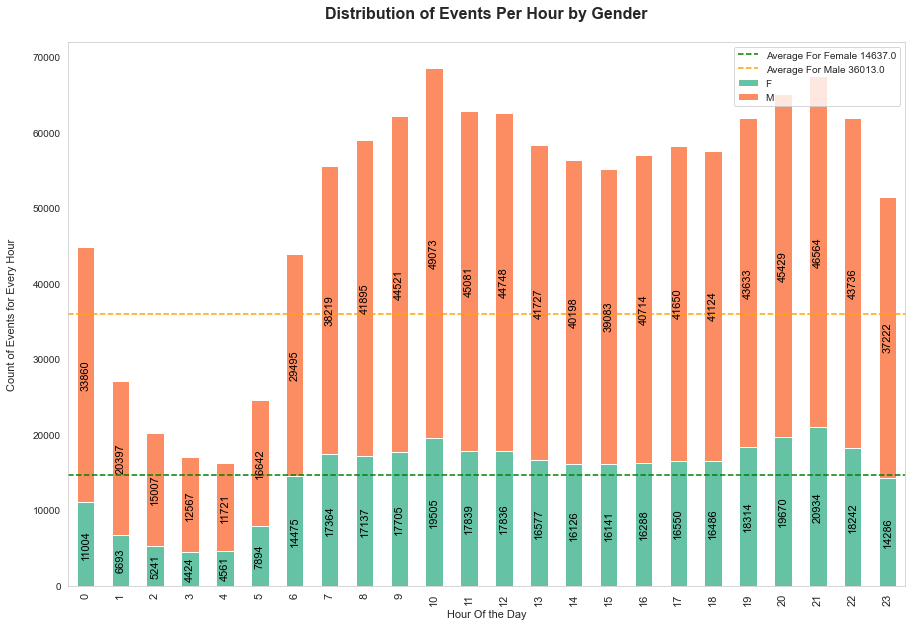

In [39]:
sns.set_palette("Set2")
res = dfTrainEventsWithEventData.groupby(['Hour', 'Gender']).size().unstack().plot(kind='bar', title="Hour of the Day", figsize=(15,10), stacked=True)

plt.title("Distribution of Events Per Hour by Gender\n",fontsize=16,loc="center",fontweight="bold")

avg_events_per_hour_female = dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "F"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "F"].Hour.nunique()

avg_events_per_hour_male = dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "M"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "M"].Hour.nunique()

plt.axhline(y=avg_events_per_hour_female, color='green', linestyle="--", label="Average For Female "+str(round(avg_events_per_hour_female,0)))
plt.axhline(y=avg_events_per_hour_male, color='orange', linestyle="--", label="Average For Male "+str(round(avg_events_per_hour_male,0)))

plt.legend(loc='upper right')

plt.setp( res.xaxis.get_majorticklabels(),fontsize=11)
res.set_xlabel(xlabel="Hour Of the Day",fontsize=11)
res.set_ylabel(ylabel="Count of Events for Every Hour\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', color='black', fontsize=11, rotation = 90)

plt.grid(False)
plt.show()

#### Age Group vs Event Count Comparison. Requested Age Groups - 0-24, 25-32, 33-45, 46+

##### Defining Function to Map AgeGroup

In [40]:
def ageGroup(x):
    if x >=0 and x<=24:
        return "0-24"
    elif x >=25 and x<=32:
        return "25-32"
    elif x >=33 and x<=45:
        return "33-45"
    else:
        return "46+"

In [41]:
dfTrainEventsWithEventData["AgeGroup"] = dfTrainEventsWithEventData.Age.map(ageGroup)
dfTrainEventsWithEventData.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup
0,-7548291590301750000,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45
1,-7548291590301750000,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,6,1,Tuesday,18,"(33.98, 116.79)",33-45
2,-7548291590301750000,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,3,2,Wednesday,18,"(33.98, 116.79)",33-45
3,-7548291590301750000,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,2,2,Wednesday,18,"(33.98, 116.79)",33-45
4,-7548291590301750000,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45


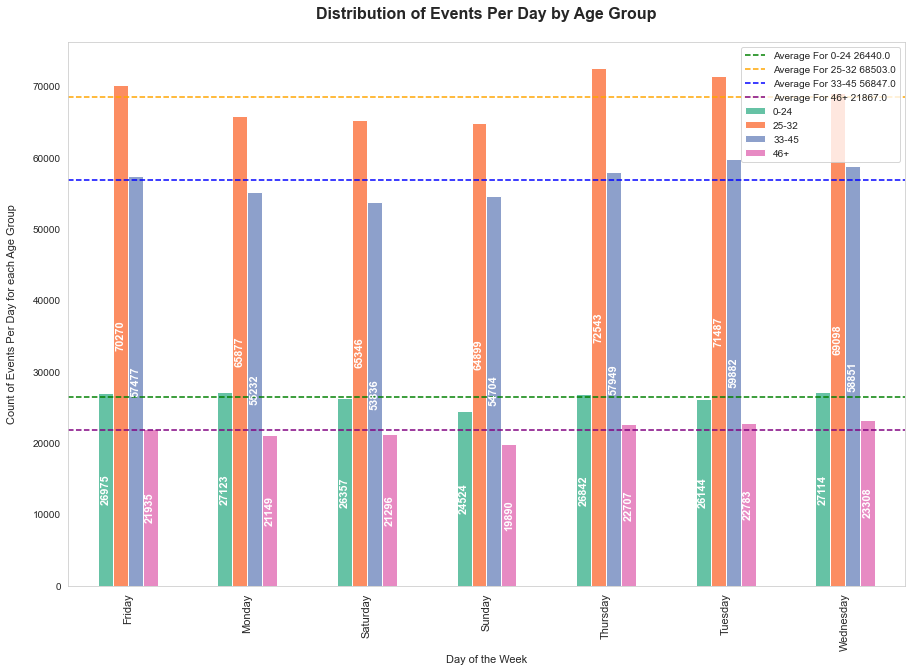

In [42]:
sns.set_palette("Set2")
res = dfTrainEventsWithEventData.groupby(['DayName', 'AgeGroup']).size().unstack().plot(kind='bar', figsize=(15,10))

plt.title("Distribution of Events Per Day by Age Group\n",fontsize=16,loc="center",fontweight="bold")

avg_events_per_day_0_24 = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "0-24"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "0-24"].AgeGroup.nunique())/7

avg_events_per_day_25_32 = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "25-32"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "25-32"].AgeGroup.nunique())/7

avg_events_per_day_33_45 = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "33-45"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "33-45"].AgeGroup.nunique())/7

avg_events_per_day_46Plus = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "46+"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.AgeGroup == "46+"].AgeGroup.nunique())/7


plt.axhline(y=avg_events_per_day_0_24, color='green', linestyle="--", label="Average For 0-24 "+str(round(avg_events_per_day_0_24,0)))
plt.axhline(y=avg_events_per_day_25_32, color='orange', linestyle="--", label="Average For 25-32 "+str(round(avg_events_per_day_25_32,0)))
plt.axhline(y=avg_events_per_day_33_45, color='blue', linestyle="--", label="Average For 33-45 "+str(round(avg_events_per_day_33_45,0)))
plt.axhline(y=avg_events_per_day_46Plus, color='purple', linestyle="--", label="Average For 46+ "+str(round(avg_events_per_day_46Plus,0)))
plt.legend(loc='upper right')

plt.setp( res.xaxis.get_majorticklabels(),fontsize=11)
res.set_xlabel(xlabel="Day of the Week",fontsize=11)
res.set_ylabel(ylabel="Count of Events Per Day for each Age Group\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', fontweight="bold", color='white', fontsize=11, rotation = 90)

plt.grid(False)
plt.show()

#### Mapping Hour to Time of the Day - Morning, Afternoon, Evening, Night

In [43]:
# Define the bins for timeframe
bins = [0, 5, 12, 16, 20, 24]

# Define the labels for timeframe
labels = ['Night', 'Morning', 'Afternoon', 'Evening', "Night"]

dfTrainEventsWithEventData["TimeOfDay"]=pd.cut(dfTrainEventsWithEventData.Hour,bins=bins,labels=labels,ordered=False,include_lowest=True)
dfTrainEventsWithEventData.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup,TimeOfDay
0,-7548291590301750000,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Afternoon
1,-7548291590301750000,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,6,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning
2,-7548291590301750000,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,3,2,Wednesday,18,"(33.98, 116.79)",33-45,Night
3,-7548291590301750000,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,2,2,Wednesday,18,"(33.98, 116.79)",33-45,Night
4,-7548291590301750000,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Afternoon


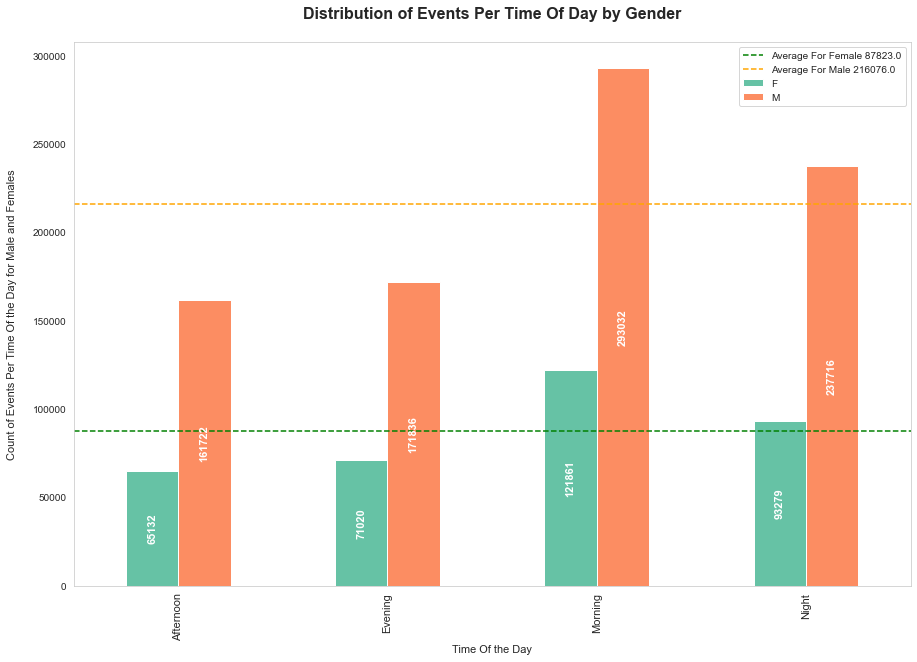

In [44]:
sns.set_palette("Set2")
res = dfTrainEventsWithEventData.groupby(['TimeOfDay', 'Gender']).size().unstack().plot(kind='bar', figsize=(15,10))

plt.title("Distribution of Events Per Time Of Day by Gender\n",fontsize=16,loc="center",fontweight="bold")

avg_events_per_timeofday_male = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "M"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "M"].TimeOfDay.nunique())

avg_events_per_timeofday_female = (dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "F"].EventID.shape[0]/dfTrainEventsWithEventData[dfTrainEventsWithEventData.Gender == "F"].TimeOfDay.nunique())

plt.axhline(y=avg_events_per_timeofday_female, color='green', linestyle="--", label="Average For Female "+str(round(avg_events_per_timeofday_female,0)))
plt.axhline(y=avg_events_per_timeofday_male, color='orange', linestyle="--", label="Average For Male "+str(round(avg_events_per_timeofday_male,0)))

plt.legend(loc='upper right')

plt.setp( res.xaxis.get_majorticklabels(),fontsize=11)
res.set_xlabel(xlabel="Time Of the Day",fontsize=11)
res.set_ylabel(ylabel="Count of Events Per Time Of the Day for Male and Females\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', fontweight="bold", color='white', fontsize=11, rotation = 90)

plt.grid(False)
plt.show()

#### Getting Frequent Travellers

In [45]:
# Getting records with location
dfTrainEventsWithEventDataAndLocation=dfTrainEventsWithEventData[dfTrainEventsWithEventData["Coordinates"]!=(0,0)]

# Merging Morning and Afternoon together, while Evening and Night Together for simplistic calculation
dfTrainEventsWithEventDataAndLocation["TimeOfDay"]=dfTrainEventsWithEventDataAndLocation["TimeOfDay"].apply(lambda x: "Evening" if x == "Night" else "Morning" if x == "Afternoon" else x)

# Getting Mode of "Coordinates" to get the maximum time a device was in at Morning or Evening
dfDeviceLocationTimeOfDay = dfTrainEventsWithEventDataAndLocation.groupby(['DeviceID', 'TimeOfDay'])["Coordinates"].agg(lambda x:x.mode().iat[0]).reset_index().pivot(index="DeviceID",columns="TimeOfDay", values = "Coordinates").reset_index()

# Filling missing location as 0
dfDeviceLocationTimeOfDay.fillna(0,inplace=True)

# Set if device user is frequent traveller throught a day
dfDeviceLocationTimeOfDay["TravellerType"]=dfDeviceLocationTimeOfDay.apply(lambda x: "Infrequent" if x["Evening"]==x["Morning"] else "Infrequent" if x["Evening"]==0 or x["Morning"]==0 else "Frequent",axis =1)

dfDeviceLocationTimeOfDay


TimeOfDay,DeviceID,Evening,Morning,TravellerType
0,-9222956879900150000,"(23.19, 113.24)","(23.19, 113.24)",Infrequent
1,-9221026417907250000,"(30.87, 114.36)","(30.87, 114.36)",Infrequent
2,-9220061629197650000,"(46.6, 124.91)","(46.6, 124.91)",Infrequent
3,-9218769147970100000,"(28.6, 112.33)",0,Infrequent
4,-9215352913819630000,0,"(22.66, 114.02)",Infrequent
...,...,...,...,...
11977,9215085115859650000,"(41.81, 123.46)",0,Infrequent
11978,9216925254504440000,"(31.32, 120.56)","(31.32, 120.56)",Infrequent
11979,9219164468944550000,"(30.27, 120.17)","(30.24, 120.16)",Frequent
11980,9219842210460030000,"(26.52, 101.72)",0,Infrequent


In [46]:
dfDeviceLocationTimeOfDay[dfDeviceLocationTimeOfDay.TravellerType == "Frequent"]

TimeOfDay,DeviceID,Evening,Morning,TravellerType
18,-9177461074950570000,"(23.68, 113.03)","(23.67, 113.04)",Frequent
25,-9167960113940180000,"(34.91, 114.95)","(31.29, 120.57)",Frequent
33,-9155576106019230000,"(32.02, 118.83)","(32.03, 118.78)",Frequent
39,-9148504360104380000,"(39.76, 98.3)","(38.94, 100.46)",Frequent
45,-9139757358587510000,"(28.63, 115.85)","(28.68, 115.88)",Frequent
...,...,...,...,...
11963,9192128233312170000,"(31.14, 121.6)","(31.15, 121.36)",Frequent
11964,9194258367022970000,"(29.87, 115.18)","(29.85, 115.21)",Frequent
11968,9197208496589780000,"(35.52, 104.51)","(26.12, 99.96)",Frequent
11974,9205029352332710000,"(35.92, 114.68)","(35.94, 114.7)",Frequent


#### Top 10 Mobile Applications

In [47]:
dfTrainEventsWithApp = pd.merge(dfTrainEventsWithEventData, dfAppEvents, how = "inner", on = "EventID")

In [48]:
dfTrainEventsWithApp.shape

(12237254, 17)

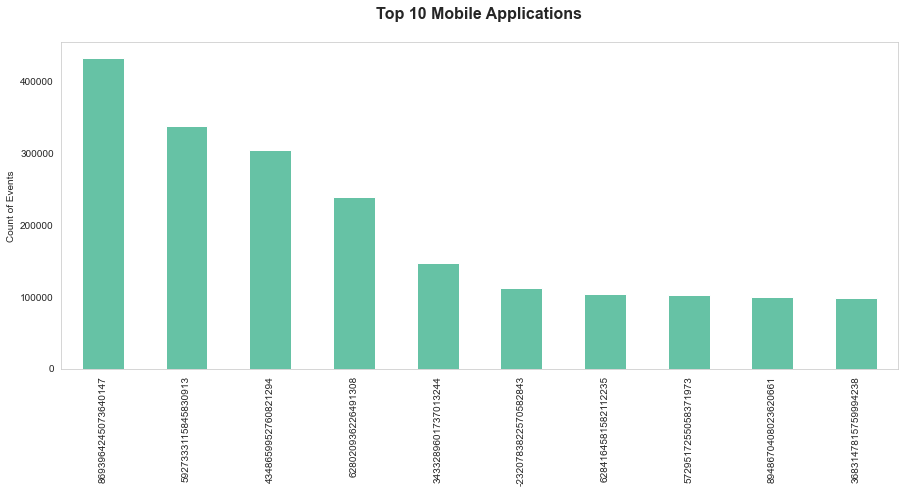

In [49]:
plt.figure(figsize=(15,6))
sns.set_palette("Set2")
dfTrainEventsWithApp["AppID"].value_counts().head(10).plot(kind="bar")
plt.ylabel('Count of Events')
plt.title('Top 10 Mobile Applications\n', fontsize=16,loc="center",fontweight="bold");
plt.grid(False)
plt.show()


#### Mapping Categories to High Level Categories

##### Category Mapping

In [50]:
category_mapping={'DS_P2P net loan' : 'Finance', 'Securities' : 'Finance', 'Lottery ticket' : 'Game', 
'IMF' : 'Finance', 'Precious Metals' : 'Finance', 'pursue' : 'Education',
'Science and Technology' : 'Education', 'Customization' : 'Shopping', 'service' : 'Services', 
'Smart Shopping' : 'Shopping', 'Personal Effectiveness' : 'Education', 'vitality' : 'Shopping',
'Trendy / cool' : 'Shopping', 'Relatives' : 'Social', 'comfortable' : 'Shopping', 'Simple' : 'Shopping',
'Debit and credit' : 'Finance', 'Crowdfunding financing' : 'Finance', 'Custom label' : 'Shopping', 
'Ping' : 'Finance', 'safety Insurance' : 'Finance', 'Peace - Search' : 'General', 
'mobile bank' : 'Finance', 'Direct Bank' : 'Finance', 'futures' : 'Finance', 
'Property Industry 1.0' : 'Finance', 'Industry tag' : 'Business', 'Pay' : 'Finance',
'Wealth Management' : 'Finance', 'Customized 1' : 'NA', '1 free' : 'NA', 'Cozy 1' : 'Shopping',
'Services 1' : 'Shopping', 'Pursuit 1' : 'Shopping', 'Noble 1' : 'Shopping', 'Trendy / cool 1' : 'Shopping',
'Passion 1' : 'Shopping', 'Personal Effectiveness 1' : 'Shopping', 'Total Cost 1' : 'Shopping', 
'Smart Shopping 1' : 'Shopping', 'Science and Technology 1' : 'Education', 'Relatives 1' : 'Social',
'1 vitality' : 'Shopping', 'Irritation / Fun 1' : 'Entertainment', 'Quality 1' : 'Shopping', 
'1 reputation' : 'General', 'Nature 1' : 'Nature', 'Simple 1' : 'Others', 'Classical 1' : 'Entertainment',
'Property Industry 2.0' : 'Finance', 'Occupational identity' : 'Others', 'College Students' : 'Education',
'Condition of the vehicles' : 'Travel', 'Bank financing' : 'Finance', 'Internet banking' : 'Finance', 
'stock' : 'Finance', 'Insurance' : 'Finance', 'other' : 'Others', 'fund' : 'Finance', 
'Stock Futures' : 'Finance', 'Trust' : 'Finance', 'Consumer loans' : 'Finance',
'Financial Services' : 'Finance', 'fixed income' : 'Finance', 'P2P' : 'Finance', 'Direct Banking' : 'Finance',
'Crowdfunding' : 'Finance', 'A shares' : 'Finance', 'Life Insurance' : 'Finance', 
'Financial Supermarket' : 'Finance', 'exchange rate' : 'Finance', 'Financial Information' : 'Finance',
'Commodity Futures' : 'Finance', 'Monetary Fund' : 'Finance', 'Bond Fund' : 'Finance', 
'Real Estate Trust' : 'Finance', 'Third party payment' : 'Finance', 'Antique collection' : 'Shopping',
'Other shares' : 'Finance', 'H shares' : 'Finance', 'Financial Futures' : 'Finance', 
'Equity Fund' : 'Finance', 'Trust funds' : 'Finance', 'N shares' : 'Finance', 'Low risk' : 'Finance', 
'Low Risk' : 'Finance', 'Medium risk' : 'Finance', 'High risk' : 'Finance', 'Liquid medium' : 'Finance', 
'Lower liquidity' : 'Finance', 'Low liquidity' : 'Finance', 'High mobility' : 'Finance', 
'High Flow' : 'Finance', 'Low profitability' : 'Finance', 'Low income' : 'Finance', 
'Moderate profitability' : 'Finance', 'Higher income' : 'Finance', 'High profitability' : 'Finance',
'And the Church' : 'Religion', 'Direct Insurance' : 'Finance', 'Exchange' : 'Finance', 
'Casual puzzle categories' : 'Game', 'ARPG' : 'Game', 'MMO' : 'Game', 'Cards RPG' : 'Game', 
'The elimination of class' : 'Game', 'read' : 'Education', 'MOBA' : 'Game', 
'Pirated content' : 'Entertainment', 'SLG (strategy)' : 'Game', 'Chess categories' : 'Game', 
'Tower Defense' : 'Game', 'Flight Shooting' : 'Game', 'Online booking class' : 'Travel', 
'Other Read' : 'Entertainment', 'Racing (RAC)' : 'Game', 'Parkour avoid class' : 'Game', 'round' : 'General',
'Shootout Shooting (STG)' : 'Game', 'Business simulation' : 'Game', 'music' : 'Entertainment',
'Listening to books category' : 'Entertainment', '"Read the operators"' : 'Education', 'Buy class' : 'Travel',
'Sports' : 'Sports', 'User Community' : 'General', 'Vermicelli' : 'Grocery', 
'Animation aggregate class' : 'Art', 'Class animation community' : 'Art', 'Hardware Related' : 'Technology',
'game' : 'Game', 'literature' : 'Entertainment', 'the film' : 'Entertainment', 'Animation' : 'Game',
'Tencent' : 'Game', 'Comics Reading Tools' : 'Game', 'Doctors' : 'Health', 'Pregnant baby' : 'Heallth',
'Prepare baby' : 'Health', 'Maternal and child population' : 'Health', 'Parenting stage' : 'Education',
'Families with big baby' : 'Social', 'Families with small babies' : 'Social', 
'Families with babies' : 'Social', 'noble' : 'General', 'Total Cost' : 'Finance', 'natural' : 'Nature',
'quality' : 'Shopping', 'Cool trendy' : 'Fashion', 'Reputation' : 'Others', 'Enthusiasm' : 'Others',
'classical' : 'Others', 'Stimulate fun' : 'Entertainment', 'Property Industry new' : 'Finance',
'Low Cost Airlines' : 'Travel', 'High-end business aviation' : 'Business',
'Full Service Airlines' : 'Travel', 'General Aviation' : 'Travel', 'Regional Aviation' : 'Travel',
'Airline type' : 'Travel', 'aviation' : 'Travel', 'Air Travel' : 'Travel', 'Airline Alliances' : 'Travel',
'Aeronautical Information Service' : 'Travel', 'airport' : 'Travel',
'Aviation Integrated Services' : 'Travel', 'Southeast Asia (aviation)' : 'Travel', '"Hong Kong' : 'Travel',
'"Europe' : 'Travel', 'Japan and South Korea (Air)' : 'Travel', 'Chinese mainland (Airlines)' : 'Travel',
'Flight area' : 'Travel', 'Travel Travel' : 'Travel', 'Overseas travel' : 'Travel',
'Domestic travel' : 'Travel', 'Tour around' : 'Travel', 'Integrated tourism' : 'Travel',
'Purpose of travel' : 'Travel', 'travel' : 'Travel', 'Free exercise' : 'Travel',
'Travel Information' : 'Travel', 'Share Tour' : 'Travel', 'Travel preferences' : 'Travel',
'Southeast Asia (Travel)' : 'Travel', 'Japan and South Korea (Travel)' : 'Travel',
'Destination Region' : 'Travel', 'High-speed rail train reservation' : 'Travel',
'Integrated Air Travel Booking' : 'Travel', 'Integrated ticket reservation' : 'Travel',
'Book hotel complex' : 'Travel', 'Coach reservations' : 'Travel', 'Booking channels' : 'Travel',
'High-end hotel' : 'Travel', 'Hotel Chain' : 'Travel', 'Non-standard accommodation' : 'Travel',
'Hotel Type' : 'Travel', 'Hotels' : 'Travel', 'financial' : 'Finance', 'Xian Xia' : 'Others',
'effort' : 'Others', 'navigation' : 'Travel', 'Tomb' : 'Others', 'reality show' : 'Entertainment',
'Jin Yong' : 'Others', 'Senki' : 'Others', 'Journey' : 'Travel', 'tribe' : 'Others', 'Ninja' : 'Game',
'Romance' : 'Entertainment', 'Shushan' : 'Entertainment', 'Martial arts' : 'Art',
'Domestic animation' : 'Art', 'Europe and Fantasy' : 'Travel', 'Harem' : 'Game', 'trickery' : 'Game',
'fashion' : 'Fashion', 'game-Cutting things' : 'Game', 'game-Finding fault' : 'Game',
'game-stress reliever' : 'Game', 'game-pet' : 'Game', 'game-Answer' : 'Game', 'game-Fishing' : 'Game',
'game-Music and Dance' : 'Game', 'game-Puzzle' : 'Game', 'game-Adventure puzzle' : 'Game',
'game-Parkour' : 'Game', 'game-Racing' : 'Game', 'game-Motorcycle' : 'Game', 'game-Rowing' : 'Game',
'game-aircraft' : 'Game', 'game-Box' : 'Game', 'game-gem' : 'Game', 'game-Lianliankan' : 'Game',
'game-Zuma' : 'Game', 'game-Bobble' : 'Game', 'game-Cartoon' : 'Game', 'game-Role -playing games' : 'Game',
'game-Competitive action' : 'Game', 'game-Tactics' : 'Game', 'game-card' : 'Game',
'game-Business simulation' : 'Game', 'game-Horizontal version' : 'Game', 'game-shooting' : 'Game',
'game-3D' : 'Game', 'game-flight' : 'Game', 'game-tank' : 'Game', 'game-Snipe' : 'Game',
'poker game_doudizhu' : 'Game', 'chess' : 'Game', 'majiang' : 'Game', 'table game' : 'Game',
'Texas Poker' : 'Game', 'poker' : 'Game', 'Puzzle' : 'Game', 'Literacy Games' : 'Game',
'Intellectual development game' : 'Game', 'math' : 'Education', 'checkpoints game' : 'Game',
'Beach landing game' : 'Game', 'old style game' : 'Game', 'basketball' : 'Game', 'football' : 'Game',
'tennis' : 'Game', 'billards' : 'Game', 'other ball game' : 'Game', 'Turn based RPG game' : 'Game',
'realtime fighting' : 'Game', 'war chess' : 'Game', 'business' : 'Game', 'farm' : 'Game',
'pet raising up' : 'Game', 'love raising up' : 'Game', 'puzzel' : 'Game', 'gambling' : 'Game',
'3 kindom game' : 'Game', 'knight game' : 'Game', 'Cultivation fantasy game' : 'Game',
'Journey to the West game' : 'Game', 'Outlaws of the Marsh game' : 'Game',
'Chinese Classical Mythology' : 'Game', 'Western Mythology' : 'Game',
'80s Japanese comic' : 'Entertainment', '90s Japanese comic' : 'Game', 'movie' : 'Entertainment',
'shows' : 'Entertainment', 'millitary and wars' : 'Entertainment', 'science fiction' : 'Entertainment',
'zombies game' : 'Entertainment', 'World of Warcraft' : 'Entertainment', 'magic' : 'Entertainment',
'dotal-lol' : 'Others', 'sailing game' : 'Game', 'sports' : 'Sports', 'Chinese painting' : 'Art',
'japanese and korean style' : 'Art', 'japanese comic and animation' : 'Entertainment',
'US and Europe animation' : 'Entertainment', 'Cute style comic' : 'Entertainment',
'pixel style comic' : 'Entertainment', 'violence comic' : 'Entertainment',
'US and Europe magic comic' : 'Entertainment', 'realistic style comic' : 'Entertainment',
'chinese comic' : 'Entertainment', 'online malls' : 'Shopping', '"online shopping by group' : 'Shopping',
'online shopping navigation' : 'Shopping', '"online shopping' : 'Shopping',
'Sea Amoy' : 'Others', 'education for babies' : 'Education', 'education outside class' : 'Education',
'foreign language' : 'Education', 'professional skills' : 'Education',
'art and culture' : 'Art', 'exams' : 'Education', 'class managemetn' : 'Education',
'children books' : 'Education', 'novels' : 'Education', 'magazine and journal' : 'Education',
'comics' : 'Education', 'dictionary' : 'Education', 'reading platform' : 'Education',
'poetry' : 'Art', 'joke' : 'Education', 'Audiobooks' : 'Education', 'science' : 'Education',
'news' : 'Education', 'Entertainment News' : 'Education', 'Sports News' : 'Education',
'Technology Information' : 'Education', 'gaming strategy' : 'Game', 'weibo' : 'Others', 
'love and marriage' : 'Social', 'community' : 'Social', 'picture sharing' : 'Social',
'radio' : 'Social', 'video' : 'Entertainment', 'show' : 'Entertainment',
'map' : 'Travel', 'Behalf of the drive' : 'Others', 'Taxi' : 'Travel', 'Car' : 'Travel',
'flight' : 'Travel', 'Bus' : 'Travel', 'train' : 'Travel', 'Hotel application' : 'Travel',
'tourism product' : 'Travel', 'coach transport' : 'Travel', 'Decoration' : 'Shopping',
'Appliances' : 'Shopping', 'Furniture' : 'Shopping', 'household products' : 'Shopping',
'Smart Home' : 'Shopping', 'Smart Appliances' : 'Shopping', 'lose weight' : 'Health',
'sports and gym' : 'Health', 'health' : 'Health', 'Medical' : 'Health',
'Health Management' : 'Health', 'Wearable Health' : 'Health', 'IM' : 'Game',
'pictures photography' : 'Photography', 'Man playing favorites' : 'Game', 'takeaway ordering' : 'Shopping',
'Astrology Horoscope' : 'Astrology', 'Reviews' : 'Entertainment', 'Recipes' : 'Education',
'Express' : 'Social', 'Accounting' : 'Education', 'Car Owners' : 'Social', 'fashion outfit' : 'Fashion',
'Integrated Living' : 'Social', 'Jobs' : 'Business', 'Scheduling' : 'Business', 'notes' : 'Business',
'File Editor' : 'Business', 'business cards' : 'Business', 'Contacts' : 'Business',
'network disk' : 'Business', 'store management' : 'Business', 'Engineering Drawing' : 'Education',
'Housing Advice' : 'Business', 'KTV' : 'Entertainment', 'Automotive News' : 'Education',
'Sale of cars' : 'Business', 'A beauty care' : 'Fashion', 'Intelligent hardware' : 'Technology',
'study abroad' : 'Education', 'RPG game' : 'Game', 'poker and chess' : 'Game',
'business strategy game' : 'Game', 'game-game type' : 'Game', 'game-Art Style' : 'Game',
'game-Gem Elimination' : 'Game', 'fighting game' : 'Game', 'raising up game' : 'Game',
'Guard tower defense game' : 'Game', 'game-Leisure time' : 'Game', 'Children puzzle game' : 'Game',
'convenience services' : 'Services', 'Beauty Nail' : 'Fashion', 'blogs' : 'Social',
'Housekeeping' : 'Services', 'System Tools' : 'Technology', 'Utilities' : 'General',
'Prepare pregnant pregnancy' : 'Health', 'Maternal and child supplies' : 'Health',
'Points Activities' : 'Others', 'management' : 'Business', 'Browser' : 'Technology',
'Desktop Enhancements' : 'Technology', 'Parenting' : 'Education', 'Buy' : 'Shopping',
'Rentals' : 'Travel', 'Weather' : 'Travel', 'coupon' : 'Shopping', 'Travel advisory' : 'Travel',
'Calendar' : 'General', 'shopping sharing' : 'Shopping', 'Clock' : 'General', 'WIFI' : 'Technology',
'Information' : 'Education', 'Share Travels' : 'Travel', 'App Store' : 'Shopping', 'Sellers' : 'Shopping',
'entertainment' : 'Entertainment', 'Academic Information' : 'Education', 'email' : 'General',
'Mother' : 'Social', 'phone' : 'General', 'psychology' : 'Education', 'Business Office' : 'Business',
'Estate' : 'Finance', 'search' : 'General', 'Make-up application' : 'Fashion',
'Skin care applications' : 'Health', 'Traditional securities brokerage' : 'Finance', 
'P2P net loan' : 'Finance', 'Third-party card management' : 'Finance',
'Internet Banking' : 'Finance', 'Consumer Finance' : 'Finance', 'Traditional Insurance' : 'Finance',
'Heritage Foundation' : 'Finance', 'Internet Securities' : 'Finance', 'Bank Credit Card' : 'Finance',
'Internet Insurance' : 'Finance', 'library' : 'Education', 'readers' : 'Education',
'Editor' : 'General', 'reading for fetus' : 'Health', 'mesasge' : 'General',
'Card Game' : 'Game', 'strategy game' : 'Game', 'cosplay' : 'Game', 'casual games' : 'Game',
'Games' : 'Game', 'Puzzles' : 'Game', 'Sports Games' : 'Game', 'action games' : 'Game',
'Educational games' : 'Game', 'Chess game' : 'Game', 'Music Games' : 'Game', 'Adventure Game' : 'Game',
'Simulators' : 'Game', 'Racing games' : 'Game', 'Table Games' : 'Game', 'Family Games' : 'Game',
'Dice Game' : 'Game', 'Word games+' : 'Game', 'Finance':'Finance', 'Word games' : 'Game',
"Read the operator's":"Education"                  
}

In [51]:
category_mapping = {k.upper():v.upper() for k,v in category_mapping.items()}
category_mapping

{'DS_P2P NET LOAN': 'FINANCE',
 'SECURITIES': 'FINANCE',
 'LOTTERY TICKET': 'GAME',
 'IMF': 'FINANCE',
 'PRECIOUS METALS': 'FINANCE',
 'PURSUE': 'EDUCATION',
 'SCIENCE AND TECHNOLOGY': 'EDUCATION',
 'CUSTOMIZATION': 'SHOPPING',
 'SERVICE': 'SERVICES',
 'SMART SHOPPING': 'SHOPPING',
 'PERSONAL EFFECTIVENESS': 'EDUCATION',
 'VITALITY': 'SHOPPING',
 'TRENDY / COOL': 'SHOPPING',
 'RELATIVES': 'SOCIAL',
 'COMFORTABLE': 'SHOPPING',
 'SIMPLE': 'SHOPPING',
 'DEBIT AND CREDIT': 'FINANCE',
 'CROWDFUNDING FINANCING': 'FINANCE',
 'CUSTOM LABEL': 'SHOPPING',
 'PING': 'FINANCE',
 'SAFETY INSURANCE': 'FINANCE',
 'PEACE - SEARCH': 'GENERAL',
 'MOBILE BANK': 'FINANCE',
 'DIRECT BANK': 'FINANCE',
 'FUTURES': 'FINANCE',
 'PROPERTY INDUSTRY 1.0': 'FINANCE',
 'INDUSTRY TAG': 'BUSINESS',
 'PAY': 'FINANCE',
 'WEALTH MANAGEMENT': 'FINANCE',
 'CUSTOMIZED 1': 'NA',
 '1 FREE': 'NA',
 'COZY 1': 'SHOPPING',
 'SERVICES 1': 'SHOPPING',
 'PURSUIT 1': 'SHOPPING',
 'NOBLE 1': 'SHOPPING',
 'TRENDY / COOL 1': 'SHOPPING',

In [52]:
#category_mapping = pd.DataFrame(category_mapping.items(), columns=["Category", "HighLevelCategory"]).drop_duplicates(subset=None, keep="first")
#category_mapping

##### Associating AppIDs with the new High Level Categories

In [53]:
dfMetaAppEventsGrouped=dfMetaAppEvents.copy()
dfMetaAppEventsGrouped=dfMetaAppEventsGrouped[(dfMetaAppEventsGrouped["Category"] != "FREE") & (dfMetaAppEventsGrouped["Category"] != "UNKNOWN")]
dfMetaAppEventsGrouped["HighLevelCategory"]=dfMetaAppEventsGrouped["Category"].map(category_mapping)
dfMetaAppEventsGrouped=dfMetaAppEventsGrouped[["AppID","HighLevelCategory"]]
dfMetaAppEventsGrouped=dfMetaAppEventsGrouped.drop_duplicates()

dfMetaAppEventsGrouped=dfMetaAppEventsGrouped.groupby("AppID").aggregate({"HighLevelCategory":list}).reset_index()
dfMetaAppEventsGrouped["HighLevelCategory"]=dfMetaAppEventsGrouped["HighLevelCategory"].apply(lambda x: x[0])
dfMetaAppEventsGrouped

,AppID,HighLevelCategory
0,-9223281467940916832,GAME
1,-9222877069545393219,EDUCATION
2,-9222785464897897681,GAME
3,-9222198347540756780,GAME
4,-9221970424041518544,NA
...,...,...
113005,9222488106573038706,ENTERTAINMENT
113006,9222542043353102991,NA
113007,9222821882765325814,GAME
113008,9223029189880985324,GAME


In [54]:
dfTrainEventsWithAppAndCategory=pd.merge(dfTrainEventsWithApp,dfMetaAppEventsGrouped,how="left",on="AppID")

In [55]:
dfTrainEventsWithAppAndCategory["HighLevelCategory"].fillna("UNKNOWN",inplace=True)
dfTrainEventsWithAppAndCategory.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup,TimeOfDay,AppID,IsActive,HighLevelCategory
0,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,3433289601737013244,1,BUSINESS
1,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,-5472633337921616096,1,NATURE
2,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,9112463114311278255,0,NA
3,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,8693964245073640147,1,FINANCE
4,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,5099453940784075687,1,EDUCATION


In [56]:
dfTrainEventsWithAppAndCategory.HighLevelCategory.value_counts(dropna=False)

FINANCE          4677522
SHOPPING         2360570
BUSINESS         2026324
NA                810573
EDUCATION         684774
UNKNOWN           337996
ENTERTAINMENT     337498
SOCIAL            334824
GAME              225280
OTHERS            168242
NATURE             69916
PHOTOGRAPHY        54545
HEALTH             44282
RELIGION           31134
TRAVEL             26500
GENERAL            24378
FASHION            12475
SERVICES            3537
TECHNOLOGY          2559
HEALLTH             2052
ASTROLOGY           1847
ART                  392
SPORTS                34
Name: HighLevelCategory, dtype: int64

In [57]:
dfTrainEventsWithAppAndCategory[dfTrainEventsWithAppAndCategory.HighLevelCategory == "NA"].head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup,TimeOfDay,AppID,IsActive,HighLevelCategory
2,-7548291590301750000,M,33,M32+,1141870,2016-05-01 10:08:16,33.98,116.79,10,6,Sunday,17,"(33.98, 116.79)",33-45,Morning,9112463114311278255,0,NA
13,6943568600617760000,M,37,M32+,1279824,2016-05-01 11:59:32,0.00,0.00,11,6,Sunday,17,"(0.0, 0.0)",33-45,Morning,3300927415001585151,1,NA
19,5441349705980020000,M,40,M32+,1814584,2016-05-02 23:55:47,0.00,0.00,23,0,Monday,18,"(0.0, 0.0)",33-45,Night,-7054804880832650555,0,NA
24,5441349705980020000,M,40,M32+,1814584,2016-05-02 23:55:47,0.00,0.00,23,0,Monday,18,"(0.0, 0.0)",33-45,Night,-143925234257082673,0,NA
29,5441349705980020000,M,40,M32+,1814584,2016-05-02 23:55:47,0.00,0.00,23,0,Monday,18,"(0.0, 0.0)",33-45,Night,1390467904297746529,0,NA


In [58]:
def map_unknown_category(x):
    if x == "NA":
        return "UNKNOWN"
    else :
        return x
dfTrainEventsWithAppAndCategory.HighLevelCategory = dfTrainEventsWithAppAndCategory.HighLevelCategory.map(map_unknown_category)

dfTrainEventsWithAppAndCategory.HighLevelCategory[dfTrainEventsWithAppAndCategory.HighLevelCategory == "NA"].value_counts()

Series([], Name: HighLevelCategory, dtype: int64)

In [59]:
round(dfTrainEventsWithAppAndCategory.HighLevelCategory.value_counts(dropna=False)/1000,0)

FINANCE          4678.0
SHOPPING         2361.0
BUSINESS         2026.0
UNKNOWN          1149.0
EDUCATION         685.0
ENTERTAINMENT     337.0
SOCIAL            335.0
GAME              225.0
OTHERS            168.0
NATURE             70.0
PHOTOGRAPHY        55.0
HEALTH             44.0
RELIGION           31.0
TRAVEL             26.0
GENERAL            24.0
FASHION            12.0
SERVICES            4.0
TECHNOLOGY          3.0
HEALLTH             2.0
ASTROLOGY           2.0
ART                 0.0
SPORTS              0.0
Name: HighLevelCategory, dtype: float64

In [60]:
dfTrainEventsWithAppAndCategory.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12237254 entries, 0 to 12237253
Data columns (total 18 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DeviceID           int64         
 1   Gender             object        
 2   Age                int64         
 3   GroupTrain         object        
 4   EventID            int64         
 5   DateTimestamp      datetime64[ns]
 6   Latitude           float64       
 7   Longitude          float64       
 8   Hour               int64         
 9   WeekDay            int64         
 10  DayName            object        
 11  WeekNum            int64         
 12  Coordinates        object        
 13  AgeGroup           object        
 14  TimeOfDay          category      
 15  AppID              int64         
 16  IsActive           int64         
 17  HighLevelCategory  object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(8), object(6)
memory usage: 1.7+ GB


In [61]:
dfTopCategories = dfTrainEventsWithAppAndCategory.HighLevelCategory.value_counts(dropna=False).reset_index()
dfTopCategories.columns = ["HighLevelCategory", "Count"]
dfTopCategories.Count = round(dfTopCategories.Count/1000,2)

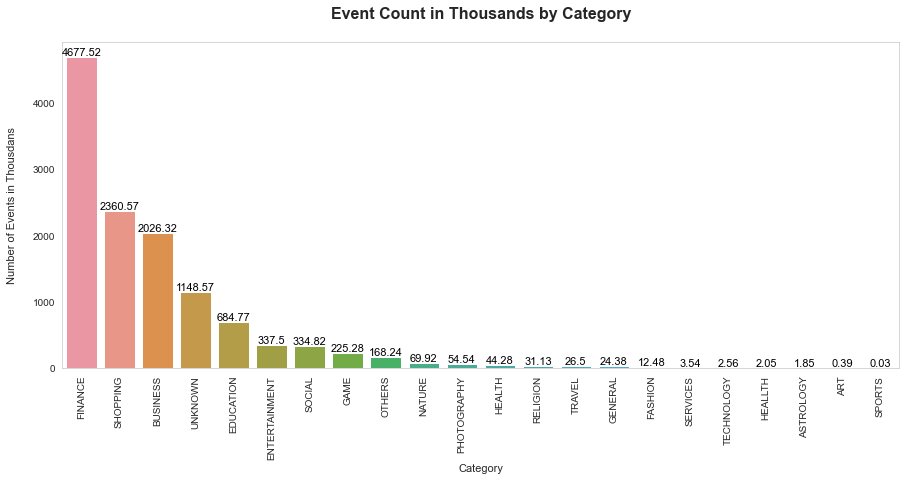

In [62]:
sns.set_palette("Set2")
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")

res = sns.barplot(x="HighLevelCategory", y="Count", data=dfTopCategories)
plt.grid(visible=False)
plt.title("Event Count in Thousands by Category\n",fontsize=16,loc="center",fontweight="bold")

plt.xticks(rotation = 90)

res.set_xlabel(xlabel="Category",fontsize=11)
res.set_ylabel(ylabel="Number of Events in Thousdans\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=11)
plt.show()

In [63]:
dfTopCategoriesMale = dfTrainEventsWithAppAndCategory[dfTrainEventsWithAppAndCategory.Gender == "M"].HighLevelCategory.value_counts(dropna=False).reset_index()
dfTopCategoriesMale.columns = ["HighLevelCategory", "Count"]
dfTopCategoriesMale.Count = round(dfTopCategoriesMale.Count/1000,2)

dfTopCategoriesFemale = dfTrainEventsWithAppAndCategory[dfTrainEventsWithAppAndCategory.Gender == "F"].HighLevelCategory.value_counts(dropna=False).reset_index()
dfTopCategoriesFemale.columns = ["HighLevelCategory", "Count"]
dfTopCategoriesFemale.Count = round(dfTopCategoriesFemale.Count/1000,2)

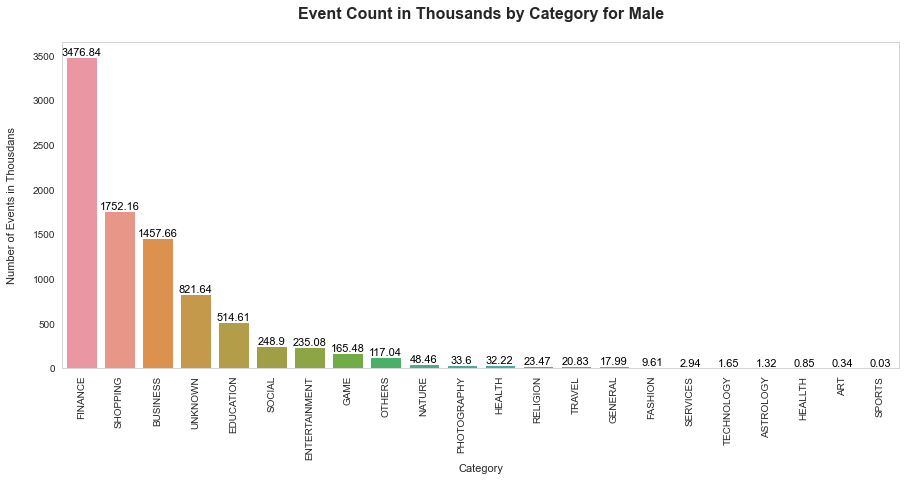

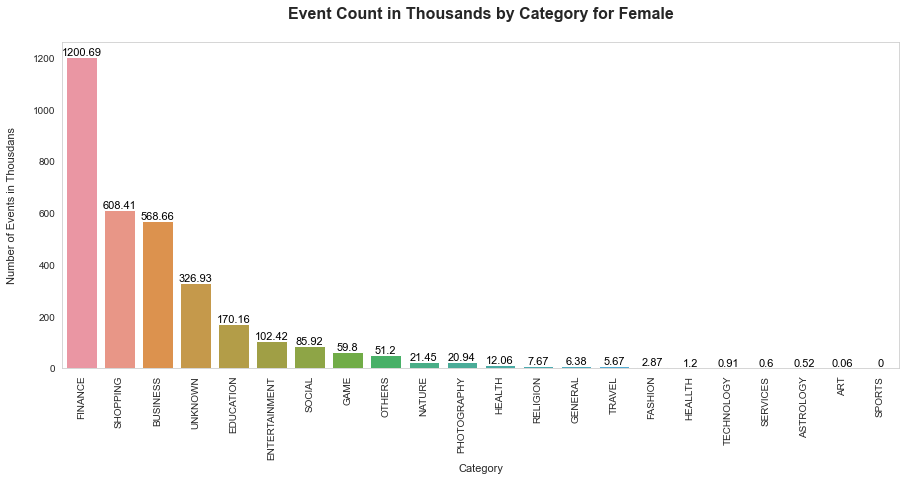

In [64]:
sns.set_palette("Set2")
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")

res = sns.barplot(x="HighLevelCategory", y="Count", data=dfTopCategoriesMale)
plt.grid(visible=False)
plt.title("Event Count in Thousands by Category for Male\n",fontsize=16,loc="center",fontweight="bold")

plt.xticks(rotation = 90)

res.set_xlabel(xlabel="Category",fontsize=11)
res.set_ylabel(ylabel="Number of Events in Thousdans\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=11)
plt.show()

sns.set_palette("Set2")
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")

res = sns.barplot(x="HighLevelCategory", y="Count", data=dfTopCategoriesFemale)
plt.grid(visible=False)
plt.title("Event Count in Thousands by Category for Female\n", fontsize=16,loc="center",fontweight="bold")

plt.xticks(rotation = 90)

res.set_xlabel(xlabel="Category",fontsize=11)
res.set_ylabel(ylabel="Number of Events in Thousdans\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=11)
plt.show()

##### Most Used App Category in each Device

In [65]:
dfDeviceTopCategoryApp = dfTrainEventsWithAppAndCategory[dfTrainEventsWithAppAndCategory["HighLevelCategory"]!="UNKNOWN"].groupby("DeviceID")["HighLevelCategory"].agg(lambda x: x.mode().iat[0]).reset_index()

dfDeviceTopCategoryApp.head()

,DeviceID,HighLevelCategory
0,-9222956879900150000,FINANCE
1,-9221026417907250000,FINANCE
2,-9220830859283100000,ENTERTAINMENT
3,-9220061629197650000,FINANCE
4,-9218960997324660000,SHOPPING


#### Mobile Brand Data

In [66]:
dfMobileBrand = dfMobileBrandTrain.groupby("DeviceID").aggregate({"MobilePhoneBrand": list, "DeviceModel": list}).reset_index()

dfMobileBrand["MobilePhoneBrand"] = dfMobileBrand["MobilePhoneBrand"].apply(lambda x: x[0])

dfMobileBrand["DeviceModel"] = dfMobileBrand["DeviceModel"].apply(lambda x: x[0])

##### Top 10 Mobile Brands

In [67]:
Top10Brands = list(dfMobileBrandTrain["MobilePhoneBrand"].value_counts(normalize=True).head(10).index)
print(Top10Brands)
dfMobileTop10BrandTrain=dfMobileBrandTrain[dfMobileBrandTrain["MobilePhoneBrand"].isin(Top10Brands)]

['XIAOMI', 'SAMSUNG', 'HUAWEI', 'OPPO', 'VIVO', 'MEIZU', 'COOLPAD', 'LENOVO', 'GIONEE', 'HTC']


In [68]:
dfMobileTop10BrandTrain.shape[0]/dfMobileBrandTrain.shape[0]

0.9138332931436379

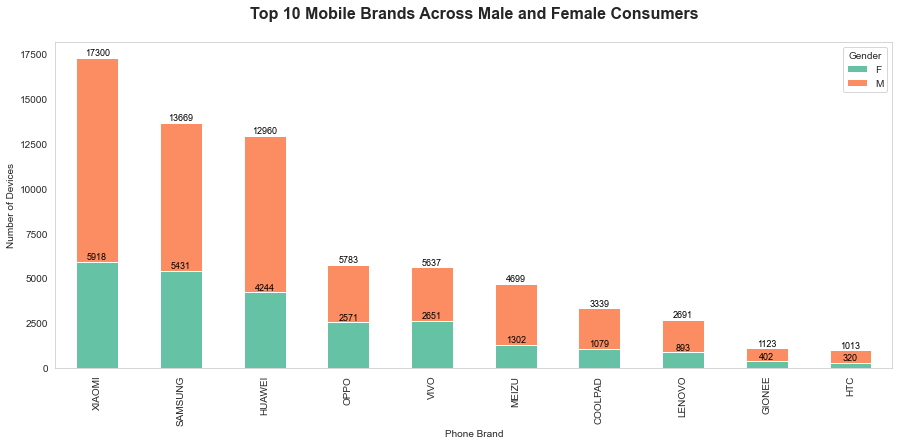

In [69]:
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(15, 6))

res = pd.pivot_table(data=dfMobileTop10BrandTrain, index="MobilePhoneBrand", columns="Gender", values="DeviceID",aggfunc="count",margins="sum",margins_name="Sum").sort_values("Sum", ascending=False).iloc[1:,:-1].plot(kind="bar",stacked=True,ax=ax)
plt.grid(visible=False)
plt.title('Top 10 Mobile Brands Across Male and Female Consumers\n',fontsize=16,loc="center",fontweight="bold")
plt.xlabel('Phone Brand')
plt.ylabel('Number of Devices')
plt.legend(title='Gender')

for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=9)

plt.show()

In [70]:
dfMobileTop10BrandTrain["AgeGroup"] = dfMobileTop10BrandTrain.Age.map(ageGroup)

dfMobileTop10BrandTrain.head()

,DeviceID,Gender,Age,GroupTrain,MobilePhoneBrand,DeviceModel,AgeGroup
0,-7548291590301750000,M,33,M32+,HUAWEI,3C,33-45
1,6943568600617760000,M,37,M32+,XIAOMI,XNOTE,33-45
2,5441349705980020000,M,40,M32+,OPPO,R7S,33-45
3,-5393876656119450000,M,33,M32+,XIAOMI,MI 4,33-45
4,4543988487649880000,M,53,M32+,SAMSUNG,GALAXY S4,46+


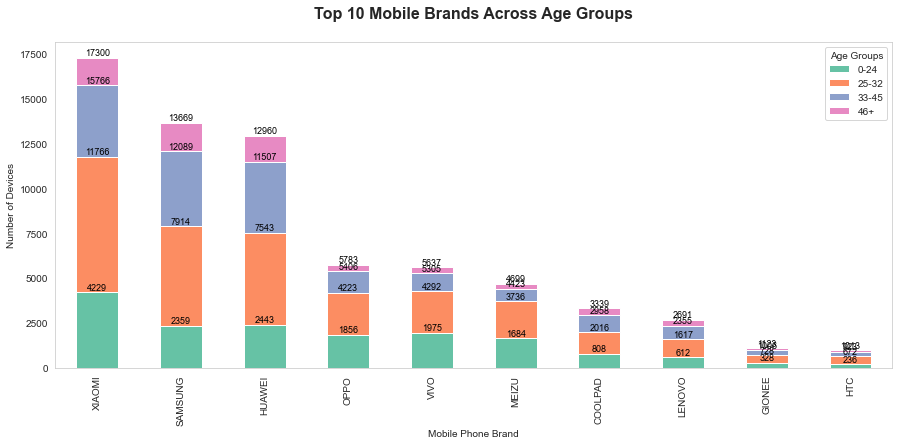

In [71]:
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(15, 6))

res = pd.pivot_table(data=dfMobileTop10BrandTrain, index="MobilePhoneBrand", columns="AgeGroup", values="DeviceID",aggfunc="count",margins="sum",margins_name="Sum").sort_values("Sum", ascending=False).iloc[1:,:-1].plot(kind="bar",ax=ax, stacked=True)
plt.grid(visible=False)
plt.title('Top 10 Mobile Brands Across Age Groups\n',fontsize=16,loc="center",fontweight="bold")
plt.xlabel('Mobile Phone Brand')
plt.ylabel('Number of Devices')
plt.legend(title='Age Groups')

for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=9)

plt.show()

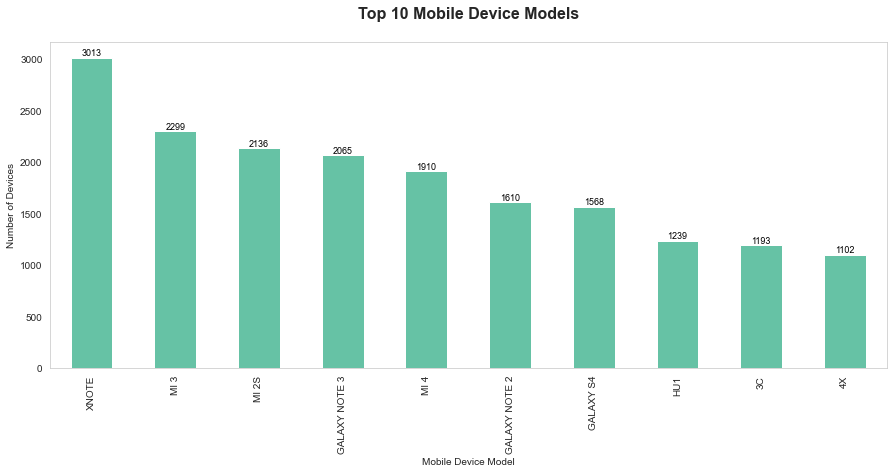

In [72]:
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(15, 6))
res = dfMobileBrandTrain["DeviceModel"].value_counts().head(10).plot(kind="bar")
plt.grid(visible=False)

plt.title('Top 10 Mobile Device Models\n',fontsize=16,loc="center",fontweight="bold")
plt.xlabel('Mobile Device Model')
plt.ylabel('Number of Devices')


for x in res.containers:
    res.bar_label(x, label_type='edge', color='black', fontsize=9)
plt.show()

#### Cluster Based on Location Data using DBSCAN

In [73]:
dfUniqueLocations = dfTrainEventsWithEventDataAndLocation[~((dfTrainEventsWithEventDataAndLocation.Latitude == 0) |  (dfTrainEventsWithEventDataAndLocation.Longitude == 0))][["Latitude", "Longitude"]].drop_duplicates(subset=None, keep="first")

dfUniqueLocations.shape

(32918, 2)

In [74]:
KMsPerRadian = 6371.0088

# epsilon = np.ones(coords.shape[0]) * 0.1 / kms_per_radian
eps_value = 100/ KMsPerRadian
coords = dfUniqueLocations.loc[:, ["Latitude", "Longitude"]].values
dbscan = DBSCAN(eps= eps_value, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_clusters

24

In [75]:
dfUniqueLocations["Cluster"] = cluster_labels

dfUniqueLocations["Coordinates"]=dfUniqueLocations[["Latitude", "Longitude"]].apply(lambda x:(x["Latitude"],x["Longitude"]), axis = 1)

dfTrainEventsWithEventDataAndLocation = pd.merge(dfTrainEventsWithEventDataAndLocation,dfUniqueLocations,how="inner",on="Coordinates")
dfTrainEventsWithEventDataAndLocation.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude_x,Longitude_x,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup,TimeOfDay,Latitude_y,Longitude_y,Cluster
0,-7548291590301750000,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,33.98,116.79,0
1,-7548291590301750000,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,6,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,33.98,116.79,0
2,-7548291590301750000,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,3,2,Wednesday,18,"(33.98, 116.79)",33-45,Evening,33.98,116.79,0
3,-7548291590301750000,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,2,2,Wednesday,18,"(33.98, 116.79)",33-45,Evening,33.98,116.79,0
4,-7548291590301750000,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,33.98,116.79,0


Text(0.5, 1.0, 'DBSCAN Location Clustering')

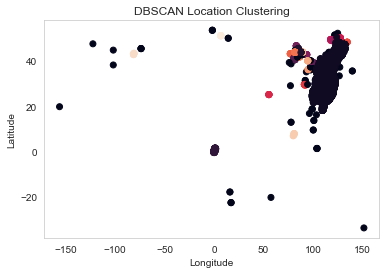

In [76]:
#Visualize the clusters
dfUniqueLocations.head()
plt.scatter(dfUniqueLocations["Longitude"],dfUniqueLocations["Latitude"],c=dfUniqueLocations["Cluster"])
plt.grid(visible=False)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Location Clustering")

In [77]:
dfClusterStats = dfTrainEventsWithEventDataAndLocation.Cluster.value_counts().reset_index()
dfClusterStats.columns = ["Cluster", "Count"]
dfClusterStats

,Cluster,Count
0,0,821740
1,2,29551
2,1,2603
3,-1,1048
4,16,616
5,11,596
6,8,478
7,5,446
8,19,367
9,3,334


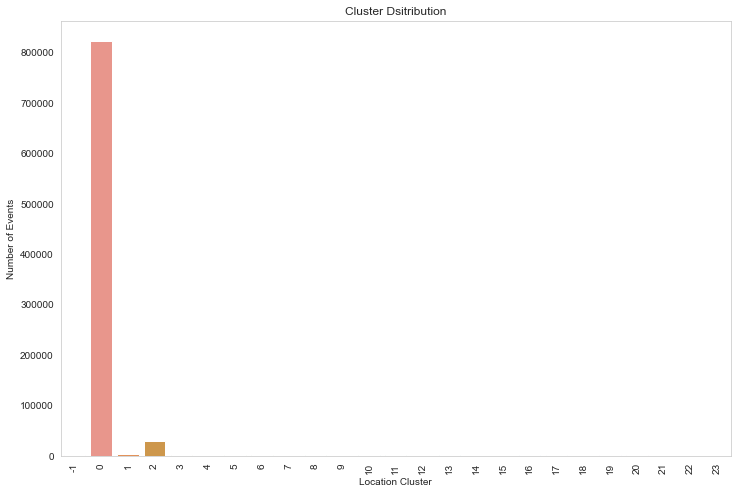

In [78]:
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
res = sns.barplot(x="Cluster", y="Count", data=dfClusterStats)
plt.grid(visible=False)
plt.title("Cluster Dsitribution")
plt.xlabel("Location Cluster")
plt.xticks(rotation = 90)
plt.ylabel("Number of Events")
plt.show()

#### Geospatial visualization

In [79]:
dfTrainEventsWithEventDataAndLocation[dfTrainEventsWithEventDataAndLocation.Longitude_x != dfTrainEventsWithEventDataAndLocation.Longitude_y].shape

(0, 18)

In [80]:
dfTrainEventsWithEventDataAndLocation.columns

Index(['DeviceID', 'Gender', 'Age', 'GroupTrain', 'EventID', 'DateTimestamp',
       'Latitude_x', 'Longitude_x', 'Hour', 'WeekDay', 'DayName', 'WeekNum',
       'Coordinates', 'AgeGroup', 'TimeOfDay', 'Latitude_y', 'Longitude_y',
       'Cluster'],
      dtype='object')

In [81]:
dfTrainEventsWithEventDataAndLocation = dfTrainEventsWithEventDataAndLocation[['DeviceID', 'Gender', 'Age', 'GroupTrain', 'EventID', 'DateTimestamp',
       'Latitude_x', 'Longitude_x', 'Hour', 'WeekDay', 'DayName', 'WeekNum',
       'Coordinates', 'AgeGroup', 'TimeOfDay',
       'Cluster']]

dfTrainEventsWithEventDataAndLocation.columns = ['DeviceID', 'Gender', 'Age', 'GroupTrain', 'EventID', 'DateTimestamp', 'Latitude', 'Longitude', 'Hour', 'WeekDay', 'DayName', 'WeekNum',
       'Coordinates', 'AgeGroup', 'TimeOfDay', 'Cluster']

dfTrainEventsWithEventDataAndLocation.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum,Coordinates,AgeGroup,TimeOfDay,Cluster
0,-7548291590301750000,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,0
1,-7548291590301750000,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,6,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,0
2,-7548291590301750000,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,3,2,Wednesday,18,"(33.98, 116.79)",33-45,Evening,0
3,-7548291590301750000,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,2,2,Wednesday,18,"(33.98, 116.79)",33-45,Evening,0
4,-7548291590301750000,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,15,1,Tuesday,18,"(33.98, 116.79)",33-45,Morning,0


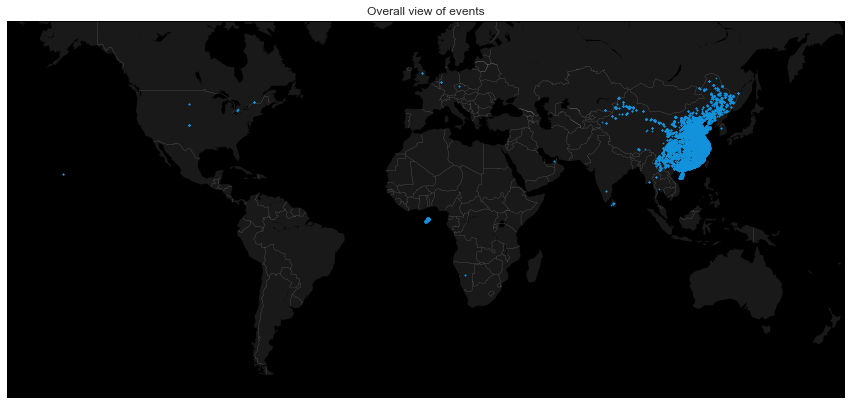

In [82]:
dfTrainEventsWithEventDataAndLocationSample = dfTrainEventsWithEventDataAndLocation.sample(n=100000)
plt.figure(1, figsize=(15,8))

#Meractor of World
m1 = Basemap(projection='merc',
             llcrnrlat = -60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(dfTrainEventsWithEventDataAndLocationSample["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSample["Latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Overall view of events")
plt.show()

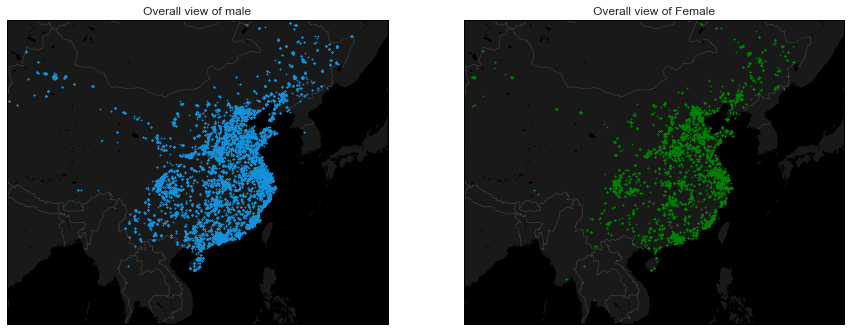

In [83]:

dfTrainEventsWithEventDataAndLocationSampleMale = dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample["Gender"]=="M"]
dfTrainEventsWithEventDataAndLocationSampleFemale = dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample["Gender"]=="F"]
lon_min, lon_max = 80, 140
lat_min, lat_max = 10, 50

plt.figure(2, figsize=(15,12))
plt.subplot(1,2,1)
m1 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(dfTrainEventsWithEventDataAndLocationSampleMale["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSampleMale["Latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Overall view of male")

plt.subplot(1,2,2)
m2 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000') # balck background
m2.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy2 = m2(dfTrainEventsWithEventDataAndLocationSampleFemale["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSampleFemale["Latitude"].tolist())
m2.scatter(mxy2[0], mxy2[1], s=3, c="green", lw=0, alpha=1, zorder=5)


plt.title("Overall view of Female")
plt.show()

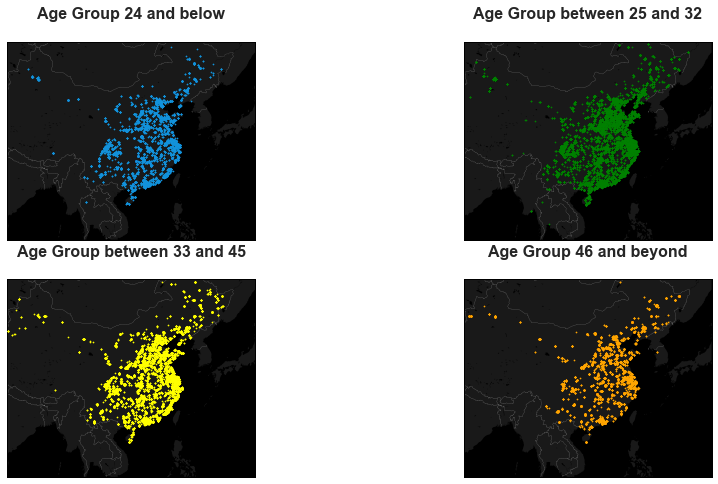

In [84]:
plt.figure(2, figsize=(15,8))
plt.subplot(2,2,1)
m1 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "0-24"]["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "0-24"]["Latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Age Group 24 and below\n", fontweight="bold", fontsize=16)

plt.subplot(2,2,2)
m2 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000') # balck background
m2.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy2 = m2(dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "25-32"]["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "25-32"]["Latitude"].tolist())
m2.scatter(mxy2[0], mxy2[1], s=3, c="green", lw=0, alpha=1, zorder=5)

plt.title("Age Group between 25 and 32\n", fontweight="bold", fontsize=16)

plt.subplot(2,2,3)
m3 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m3.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m3.drawmapboundary(fill_color='#000000') # balck background
m3.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy3 = m3(dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "33-45"]["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "33-45"]["Latitude"].tolist())
m3.scatter(mxy3[0], mxy3[1], s=3, c="yellow", lw=0, alpha=1, zorder=5)

plt.title("Age Group between 33 and 45\n", fontweight="bold", fontsize=16)

plt.subplot(2,2,4)
m3 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m3.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m3.drawmapboundary(fill_color='#000000') # balck background
m3.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy3 = m3(dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "46+"]["Longitude"].tolist(), dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.AgeGroup == "46+"]["Latitude"].tolist())
m3.scatter(mxy3[0], mxy3[1], s=3, c="orange", lw=0, alpha=1, zorder=5)

plt.title("Age Group 46 and beyond\n", fontweight="bold", fontsize=16)

plt.show()

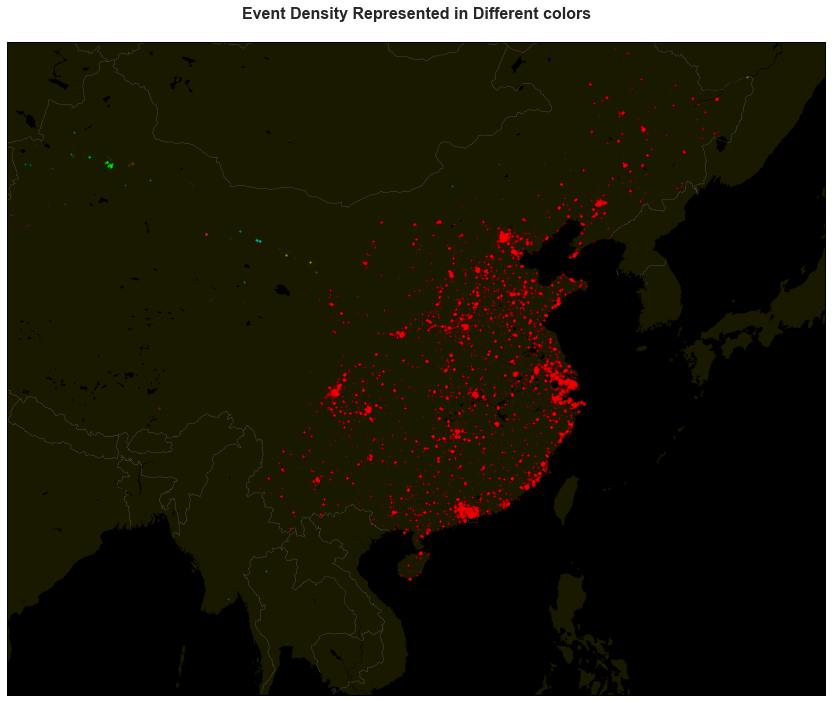

In [85]:
mxy = []
j = 0
plt.figure(2, figsize=(15,12))

m2 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191900', lake_color='#000000') #dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000') # balck background
m2.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data

for i in set(dfTrainEventsWithEventDataAndLocationSample.Cluster.unique()):
  mxy.append(m2(dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.Cluster == i]["Longitude"].to_list(), dfTrainEventsWithEventDataAndLocationSample[dfTrainEventsWithEventDataAndLocationSample.Cluster == i]["Latitude"].to_list()))
  j = j+1

cluster_color_map = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#800000",  # Maroon
    "#008000",  # Dark Green
    "#000080",  # Navy
    "#808000",  # Olive
    "#800080",  # Purple
    "#008080",  # Teal
    "#FFA500",  # Orange
    "#A52A2A",  # Brown
    "#F0E68C",  # Khaki
    "#800000",  # Dark Red
    "#008000",  # Green
    "#000080",  # Dark Blue
    "#FFC0CB",  # Pink
    "#FF1493",  # Deep Pink
    "#FF4500",  # Orange Red
    "#F0FFFF",  # Azure
    "#FF00FF",  # Fuchsia
    "#FFFF00",  # Lime
    "#00FFFF"   # Aqua
]


for i in range(j):
  m2.scatter(mxy[i][0], mxy[i][1], s=5, c=cluster_color_map[i], lw=0, alpha=0.05, zorder=5)

plt.title("Event Density Represented in Different colors\n", fontsize=16, fontweight="bold")
plt.show()

In [86]:
dfDeviceEventCount=dfTrainEventsWithEventData.groupby("DeviceID").count()["EventID"].reset_index()
dfDeviceEventCount=dfDeviceEventCount.rename(columns={"EventID":"EventCount"})
dfDeviceEventCount.head()

,DeviceID,EventCount
0,-9222956879900150000,65
1,-9221026417907250000,147
2,-9220830859283100000,8
3,-9220061629197650000,52
4,-9218960997324660000,6


In [87]:
dfDeviceCluster=dfTrainEventsWithEventDataAndLocation.groupby(['DeviceID'])[['Cluster']].agg(lambda x:x.mode().iat[0])

dfDeviceCluster.head()

,Cluster
DeviceID,
-9222956879900150000,0
-9221026417907250000,0
-9220061629197650000,0
-9218769147970100000,0
-9215352913819630000,0


In [88]:
from __future__ import print_function  # for Python2
import sys
SizeOfDataFrames = []

local_vars = list(locals().items())
for var, obj in local_vars:
  if var.startswith("df"):
    SizeOfDataFrames.append([var])

SizeOfDataFrames = np.array(SizeOfDataFrames)
SizeOfDataFrames = pd.DataFrame(SizeOfDataFrames)

SizeOfDataFrames.columns = ["DataFrame"]

SizeOfDataFrames.sort_values("DataFrame")

,DataFrame
0,dfAppEvents
17,dfClusterStats
22,dfDeviceCluster
21,dfDeviceEventCount
6,dfDeviceLocationTimeOfDay
13,dfDeviceTopCategoryApp
2,dfMetaAppEvents
8,dfMetaAppEventsGrouped
14,dfMobileBrand
3,dfMobileBrandTrain


In [89]:
dfDeviceTopCategoryApp

,DeviceID,HighLevelCategory
0,-9222956879900150000,FINANCE
1,-9221026417907250000,FINANCE
2,-9220830859283100000,ENTERTAINMENT
3,-9220061629197650000,FINANCE
4,-9218960997324660000,SHOPPING
...,...,...
23286,9216925254504440000,SHOPPING
23287,9217638755105360000,FINANCE
23288,9219164468944550000,FINANCE
23289,9219842210460030000,FINANCE


# Data Preparation

## Merge All necessary DataFrames

In [90]:
dfDeviceData = dfTrainEventsWithEventData[["DeviceID", "Gender", "AgeGroup"]].drop_duplicates()
dfDeviceEventsMerged = pd.merge(dfDeviceData, dfDeviceLocationTimeOfDay, how="left", on="DeviceID")
dfDeviceEventsMerged = pd.merge(dfDeviceEventsMerged, dfDeviceTopCategoryApp, how="left", on="DeviceID")
dfDeviceEventsMerged = pd.merge(dfDeviceEventsMerged, dfDeviceCluster, how="left", on="DeviceID")
dfDeviceEventsMerged = pd.merge(dfDeviceEventsMerged, dfDeviceEventCount, how="left", on="DeviceID")
dfDeviceEventsMerged = pd.merge(dfDeviceEventsMerged, dfMobileBrand, how="left", on="DeviceID")

print(dfDeviceEventsMerged.shape)

dfDeviceEventsMerged.drop(["Morning", "Evening"], axis=1, inplace=True)

dfDeviceEventsMerged["TravellerType"].fillna("Unknown", inplace=True)

dfDeviceEventsMerged["Cluster"].fillna(-99,inplace=True)

dfDeviceEventsMerged["Cluster"] = dfDeviceEventsMerged["Cluster"].astype("category")

dfDeviceEventsMerged.head()

(23310, 11)


,DeviceID,Gender,AgeGroup,TravellerType,HighLevelCategory,Cluster,EventCount,MobilePhoneBrand,DeviceModel
0,-7548291590301750000,M,33-45,Infrequent,BUSINESS,0.0,292,HUAWEI,3C
1,6943568600617760000,M,33-45,Unknown,FINANCE,-99.0,1,XIAOMI,XNOTE
2,5441349705980020000,M,33-45,Unknown,FINANCE,-99.0,1,OPPO,R7S
3,-5393876656119450000,M,33-45,Unknown,FINANCE,-99.0,4,XIAOMI,MI 4
4,4543988487649880000,M,46+,Frequent,FINANCE,0.0,115,SAMSUNG,GALAXY S4


In [91]:
dfDeviceEventsMerged.columns

Index(['DeviceID', 'Gender', 'AgeGroup', 'TravellerType', 'HighLevelCategory',
       'Cluster', 'EventCount', 'MobilePhoneBrand', 'DeviceModel'],
      dtype='object')

## Label Encoding

In [92]:
#Defining Target Columns
target_columns = ['Gender', 'AgeGroup']

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Apply label encoding on the selected columns
dfDeviceEventsMergedEncoded = dfDeviceEventsMerged.copy()
label_mappings = {}

for column in target_columns:
    encoded_labels = encoder.fit_transform(dfDeviceEventsMerged[column])
    dfDeviceEventsMergedEncoded[column] = encoded_labels
    label_mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mappings for each column
for column, mappings in label_mappings.items():
    print(f"Label Mappings for column '{column}':")
    for label, encoded_label in mappings.items():
        print(f"{label} : {encoded_label}")
    print()

Label Mappings for column 'Gender':
F : 0
M : 1

Label Mappings for column 'AgeGroup':
0-24 : 0
25-32 : 1
33-45 : 2
46+ : 3



## Train Test Split

In [93]:
dfTrainTest = pd.read_csv("train_test_split.csv")

dfTrainTest.columns = ["DeviceID", "Gender", "Age", "Group", "TrainTestFlag"]
dfTrainTest.head()


,DeviceID,Gender,Age,Group,TrainTestFlag
0,-7548291590301750000,M,33,M32+,train
1,6943568600617760000,M,37,M32+,train
2,5441349705980020000,M,40,M32+,train
3,-5393876656119450000,M,33,M32+,train
4,4543988487649880000,M,53,M32+,train


In [94]:
dfDeviceEventsMergedTrainTest=pd.merge(dfDeviceEventsMergedEncoded,dfTrainTest[["DeviceID","TrainTestFlag"]],how="inner",on="DeviceID")
dfTrain=dfDeviceEventsMergedTrainTest[dfDeviceEventsMergedTrainTest["TrainTestFlag"]=="train"]
dfTest=dfDeviceEventsMergedTrainTest[dfDeviceEventsMergedTrainTest["TrainTestFlag"]=="test"]


## Standard Scaler

In [95]:
num_columns=["EventCount"]

# Apply StandardScaler
scaler = StandardScaler()
dfTrain[num_columns] = scaler.fit_transform(dfTrain[num_columns].values)
dfTest[num_columns] = scaler.transform(dfTest[num_columns].values)
# Replace numerical columns with scaled values in the DataFrame


## Target Encoding for "Gender Prediction"

In [96]:

target_columns = ['Gender']

cat_columns = ["TravellerType", "HighLevelCategory", "Cluster", "MobilePhoneBrand", "DeviceModel"]
encoder = ce.TargetEncoder(cols=cat_columns)

encoder.fit(dfTrain, dfTrain["Gender"])
# train_df.shape


dfTrain = encoder.transform(dfTrain)
dfTest = encoder.transform(dfTest)

In [97]:
dfTrain.head()

,DeviceID,Gender,AgeGroup,TravellerType,HighLevelCategory,Cluster,EventCount,MobilePhoneBrand,DeviceModel,TrainTestFlag
0,-7548291590301750000,1,2,0.693737,0.525983,0.703997,1.938428,0.687040,0.675799,train
1,6943568600617760000,1,2,0.602807,0.672893,0.602737,-0.411785,0.650285,0.616758,train
2,5441349705980020000,1,2,0.602807,0.672893,0.602737,-0.411785,0.549481,0.491018,train
3,-5393876656119450000,1,2,0.602807,0.672893,0.602737,-0.387556,0.650285,0.642433,train
4,4543988487649880000,1,3,0.737358,0.672893,0.703997,0.508917,0.637855,0.653061,train


In [98]:
X_train=dfTrain.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)
X_test=dfTest.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)

y_gender_train=dfTrain["Gender"]
y_gender_test=dfTest["Gender"]

# Model Building

## Writing Model Functions

In [99]:
# Logistic Regression
def logistic_regression(X_train,y_train,X_test,y_test,penalty='l2', solver='lbfgs',average='binary'):
    lr = LogisticRegression(penalty=penalty,solver=solver)
    lr.fit(X_train, y_train)
    
    training_accuracy=accuracy_score(y_train,lr.predict(X_train))
# Predict the target variable for the test set
    y_pred = lr.predict(X_test)
    
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred,average=average)
    precision=precision_score(y_test,y_pred,average=average)
    F1=f1_score(y_test,y_pred,average=average)
    
    return y_pred,accuracy,training_accuracy,recall,precision,F1,lr

In [100]:
#Random Forest
def random_forest(X_train,y_train,X_test,y_test,average='binary',**params):
    rf=RandomForestClassifier(**params,random_state=100)
    rf.fit(X_train,y_train)
    
    training_accuracy=accuracy_score(y_train,rf.predict(X_train))
# Predict the target variable for the test set
    y_pred = rf.predict(X_test)
    
    
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred,average=average)
    precision=precision_score(y_test,y_pred,average=average)
    F1=f1_score(y_test,y_pred,average=average)
    
    return y_pred,accuracy,training_accuracy,recall,precision,F1,rf

In [101]:
#XG Boost
def xg_boost(X_train,y_train,X_test,y_test,average='binary',**params):
    xgb=XGBClassifier(**params,random_state=100)
    xgb.fit(X_train,y_train)
    
    training_accuracy=accuracy_score(y_train,xgb.predict(X_train))
    # Predict the target variable for the test set
    y_pred = xgb.predict(X_test)
    
    
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred,average=average)
    precision=precision_score(y_test,y_pred,average=average)
    F1=f1_score(y_test,y_pred,average=average)
    
    return y_pred,accuracy,training_accuracy,recall,precision,F1,xgb

In [102]:
def model_stacking(X_train,y_train,X_test,y_test,classifiers,meta_classifier,average='binary'):
    
    stacking = StackingCVClassifier(classifiers=classifiers, meta_classifier=meta_classifier, use_probas=True, cv=3)
    stacking.fit(X_train,y_train)
    
    training_accuracy=accuracy_score(y_train,stacking.predict(X_train))
    
    # Predict the target variable for the test set
    y_pred = stacking.predict(X_test)
    
    
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred,average=average)
    precision=precision_score(y_test,y_pred,average=average)
    F1=f1_score(y_test,y_pred,average=average)
    
    return y_pred,accuracy,training_accuracy,recall,precision,F1,stacking

In [103]:
# Cross Validation
def cross_validation(X_train,y_train,X_test,y_test,model,param_grid,k_fold=3,scoring="accuracy"):
    
    
    cv=GridSearchCV(model,param_grid=param_grid,cv=k_fold,return_train_score=True,n_jobs=-1,scoring=scoring)
    cv.fit(X_train,y_train)
    training_accuracy=accuracy_score(y_train,cv.predict(X_train))
# Predict the target variable for the test set
    y_pred = cv.predict(X_test)
    
    accuracy=accuracy_score(y_test,y_pred)
    
    
    return y_pred,accuracy,training_accuracy,cv,cv.best_score_,cv.best_params_

In [104]:
def confusion_matrix_plot(model,X_test,y_test):
    plt.figure(figsize=(8,5))
    y_pred = model.predict(X_test)
    confusion_matrix1  = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.grid(False)
    plt.show()

In [105]:
def plot_roc_curve(model,X_test,y_test,label):
    y_score = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc_scr = roc_auc_score(y_test,y_score[:,1])
    # print(fpr, tpr, thresholds)
    print("ROC AUC SCORE -> ", roc_auc_scr)
    plt.figure(figsize=(8,5))
    plt.plot(fpr,tpr,linestyle = '-',color = 'green',label=label)

    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    #plt.grid(b=False)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title('AUC-ROC Curve' + label)
    plt.plot(p_fpr,p_tpr,linestyle='--',color = 'blue')
    plt.show()

In [106]:
def lift_gain(model,X_train,y_train):
    # Predict probabilities for the training data
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]

    # Sort the predicted probabilities in ascending order
    sorted_probs = np.sort(y_train_pred_proba)

    # Calculate the number of samples per decile
    n = len(sorted_probs)
    decile_size = n // 10

    # Divide the probabilities into deciles
    deciles = [sorted_probs[i*decile_size: (i+1)*decile_size] for i in range(10)]

    # Calculate cumulative response rate and cumulative capture rate for each decile
    cumulative_response = [np.sum(y_train[i*decile_size: (i+1)*decile_size]) for i in range(10)]
    cumulative_capture = np.cumsum(cumulative_response) / np.sum(y_train)

    # Calculate KS statistic for each decile
    ks_statistic = np.abs(np.arange(1, 11) / 10 - cumulative_capture)

    # Sort the deciles based on the KS statistic
    sorted_deciles = np.argsort(ks_statistic)
    
    # Convert sorted_deciles to an integer array
    sorted_deciles = sorted_deciles.astype(int)

    # Get the probability bands for the top 3 and bottom 3 deciles
#     top_deciles = deciles[sorted_deciles[-3:]]
#     bottom_deciles = deciles[sorted_deciles[:3]]
    top_deciles=[]
    for i in sorted_deciles[-3:]:
        top_deciles.extend(deciles[i])
    top_decile_prob=min(top_deciles)
    
    bottom_deciles=[]
    for i in sorted_deciles[:3]:
        bottom_deciles.extend(deciles[i])
    bottom_deciles_prob=max(bottom_deciles)

    # Print the probability bands for the top 3 and bottom 3 deciles
    return top_decile_prob,bottom_deciles_prob,ks_statistic


In [107]:
def evaluation_metrics(model,X_test,y_test,label,accuracy,training_accuracy,recall,precision,F1,model_type,multiclass=False):
    
    top_decile_prob,bottom_deciles_prob,ks_statistic=lift_gain(model,X_test,y_test)
    
    print("---------------Model Statistics---------------")
    print(model_type + " Model Accuracy:",accuracy)
    print(model_type + " Model training Accuracy:",training_accuracy)
    print(model_type + " Model Precision:",precision)
    print(model_type + " Model Recall:",recall)
    print(model_type + " Model F1 Score:",F1)
    
    print("---------------Confusion Matrix---------------")
    confusion_matrix_plot(model,X_test,y_test)
    
    
    
    if multiclass:
        print("---------------Multiclass Log Loss---------------")
        y_pred_proba = model.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred_proba)
        print("Multiclass Log Loss: {:.4f}".format(logloss))
    else:
        print("---------------Decile Analysis---------------")
        print("Top Probability:",top_decile_prob)
        print("Bottom Probability:",bottom_deciles_prob)
        print("KS Statistic")
        for i in range(10):
            print("Decile " + str(i) + ":",ks_statistic[i])
        print("---------------ROC Curve---------------")
        plot_roc_curve(model,X_test,y_test,label)

## Scenario 1 - Devices with Events

## Gender Prediction

### Gender Prediction - Logistic Regression

---------------Model Statistics---------------
Gender Model Accuracy: 0.6585449553877831
Gender Model training Accuracy: 0.6712046676581627
Gender Model Precision: 0.6744539411206077
Gender Model Recall: 0.9278808466161484
Gender Model F1 Score: 0.7811262648482182
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

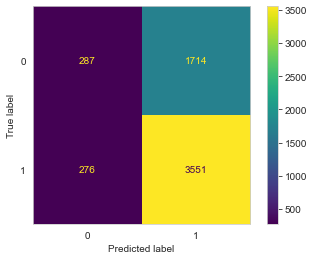

---------------Decile Analysis---------------
Top Probability: 0.5565661867199909
Bottom Probability: 0.6351541776190011
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6087205286826145


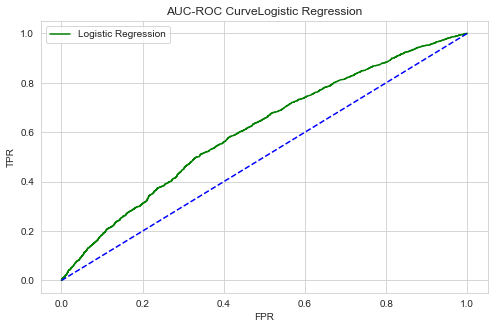

In [108]:
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_gender_1 = logistic_regression(X_train,y_gender_train,X_test,y_gender_test)

evaluation_metrics(lr_gender_1,X_test,y_gender_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Gender")

---------------Model Statistics---------------
Gender Model Accuracy: 0.6592312971859986
Gender Model training Accuracy: 0.6721770964420547
Gender Model Precision: 0.6752999428680251
Gender Model Recall: 0.9265743402142671
Gender Model F1 Score: 0.7812293456708526
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

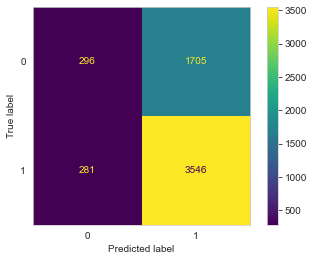

---------------Decile Analysis---------------
Top Probability: 0.5541848484717005
Bottom Probability: 0.6336813151193647
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6074034448675845


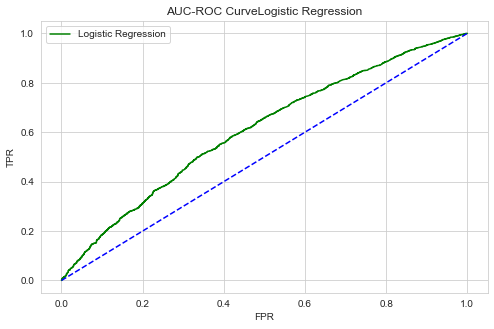

In [109]:
#Applying L1 Regularization
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_gender_2 = logistic_regression(X_train,y_gender_train,X_test,y_gender_test,penalty='l1', solver='liblinear')
evaluation_metrics(lr_gender_2,X_test,y_gender_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Gender")

In [110]:
# Since second model gives better accuracy, making second model as final logistic regression model
lr_gender=lr_gender_2

### Gender Prediction - Random Forest Classifier

---------------Model Statistics---------------
Gender Model Accuracy: 0.5883665065202471
Gender Model training Accuracy: 0.8914883880562865
Gender Model Precision: 0.6713051823416507
Gender Model Recall: 0.7311209824928142
Gender Model F1 Score: 0.6999374609130706
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

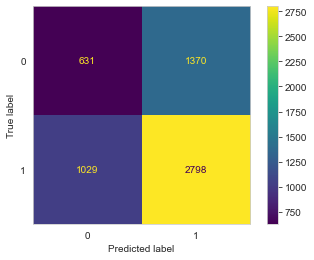

---------------Decile Analysis---------------
Top Probability: 0.4
Bottom Probability: 0.6
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5475813177811408


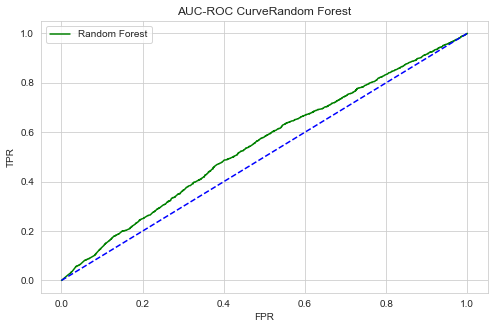

In [111]:
#Base Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_gender_1 = random_forest(X_train,y_gender_train,X_test,y_gender_test)
evaluation_metrics(rf_gender_1,X_test,y_gender_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - Random Forest Hyperparameter Tuning

#### Gender Prediction - Random Forest - Model 1

In [112]:
param_grid={
                "n_estimators":[120,130],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_1 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_1)

Gender Model Accuracy: 0.6551132463967055
Gender Model training Accuracy: 0.6940853449262098
Best CV Score: 0.6738931516469083
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 120, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 2

In [113]:
param_grid={
                "n_estimators":[100,120],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_2 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_2)

Gender Model Accuracy: 0.6551132463967055
Gender Model training Accuracy: 0.6940853449262098
Best CV Score: 0.6738931516469083
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 120, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 3

In [114]:
param_grid={
                "n_estimators":[80,100],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_3 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_3)

Gender Model Accuracy: 0.6556280027453671
Gender Model training Accuracy: 0.6929985127559776
Best CV Score: 0.6734926285493139
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 120, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 4

In [115]:
param_grid={
                "n_estimators":[50,80],
               "min_samples_split":[2,5],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_4 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_4)

Gender Model Accuracy: 0.6561427590940289
Gender Model training Accuracy: 0.6922548907447661
Best CV Score: 0.6736642532610265
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 5

In [116]:
param_grid={
                "n_estimators":[80],
               "min_samples_split":[2,5],
               "min_samples_leaf":[5],
               "max_leaf_nodes":[80,100],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_5 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_5)

Gender Model Accuracy: 0.6573438572409059
Gender Model training Accuracy: 0.6912824619608741
Best CV Score: 0.6724631452986097
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}


#### Gender Prediction - Random Forest - Model Selection

In [117]:
# Since Model 5 has best acccuracy score taking model 5 as final model
best_params_gender=best_params_gender_5

#### Gender Prediction - Random Forest - Best Parameters

---------------Model Statistics---------------
Gender Model Accuracy: 0.6573438572409059
Gender Model training Accuracy: 0.6912824619608741
Gender Model Precision: 0.6743521341463414
Gender Model Recall: 0.9247452312516331
Gender Model F1 Score: 0.7799449035812672
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

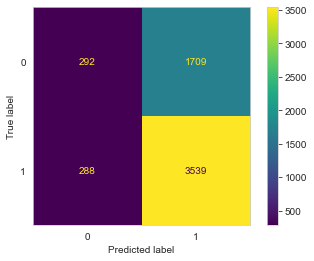

---------------Decile Analysis---------------
Top Probability: 0.5565927512322382
Bottom Probability: 0.6370836299390606
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.605671034354785


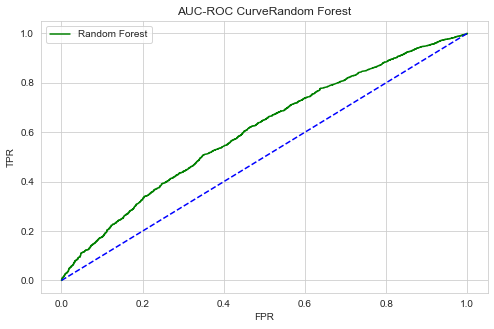

In [118]:
#Best Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_gender = random_forest(X_train,y_gender_train,X_test,y_gender_test,**best_params_gender)
evaluation_metrics(rf_gender,X_test,y_gender_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - XG Boost

---------------Model Statistics---------------
Gender Model Accuracy: 0.6329787234042553
Gender Model training Accuracy: 0.7348129504633337
Gender Model Precision: 0.6687325069972011
Gender Model Recall: 0.874052782858636
Gender Model F1 Score: 0.7577302072714917
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

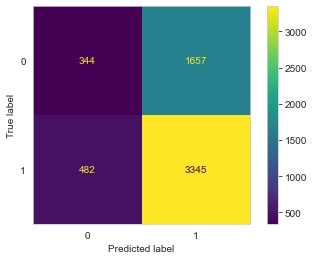

---------------Decile Analysis---------------
Top Probability: 0.5380599
Bottom Probability: 0.6196656
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5776755599205885


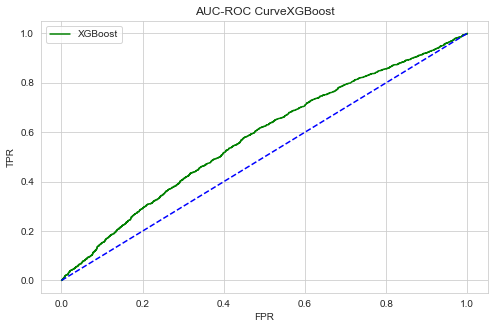

In [119]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_gender_1 = xg_boost(X_train,y_gender_train,X_test,y_gender_test)
evaluation_metrics(xgb_gender_1,X_test,y_gender_test,"XGBoost",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - XG Boost Hyperparameter Tuning

##### Gender Prediction - XG Boost Tuning Model 1

In [120]:
param_grid={"n_estimators":[10,20],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_1 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_1)

Gender Model Accuracy: 0.6528826355525051
Gender Model training Accuracy: 0.686420318041414
Best CV Score: 0.6743506735835597
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 20}


##### Gender Prediction - XG Boost Tuning Model 2

In [121]:
param_grid={"n_estimators":[20,50],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_2 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_2)

Gender Model Accuracy: 0.6597460535346603
Gender Model training Accuracy: 0.679155703008809
Best CV Score: 0.6745795228917428
Best Paramater: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}


##### Gender Prediction - XG Boost Tuning Model 3

In [122]:
param_grid={"n_estimators":[20,50],
           "max_depth":[3,6],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [2, 3],
            'gamma': [0.2, 0.3]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_3 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_3)

Gender Model Accuracy: 0.6595744680851063
Gender Model training Accuracy: 0.6784692826907677
Best CV Score: 0.6732065448291206
Best Paramater: {'gamma': 0.3, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20}


##### Gender Prediction - XG Boost Tuning Model 4

In [123]:
param_grid={"n_estimators":[50,80],
           "max_depth":[3,6],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [2, 3],
            'gamma': [0.2, 0.3],
            
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_4 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_4)

Gender Model Accuracy: 0.6595744680851063
Gender Model training Accuracy: 0.6808145521107425
Best CV Score: 0.6722914616936588
Best Paramater: {'gamma': 0.3, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}


##### Gender Prediction - XG Boost Tuning Model 5

In [124]:
param_grid={"n_estimators":[50],
           "max_depth":[2,3],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [3,4],
            'gamma': [0.2, 0.3]
            
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_5 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_5)

Gender Model Accuracy: 0.6588881262868909
Gender Model training Accuracy: 0.6823017961331656
Best CV Score: 0.6738930829381302
Best Paramater: {'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 50}


##### Gender Prediction - XG Boost Tuning Model Selection

In [125]:
# Since Model 1 has best acccuracy score taking model 1 as final model
best_params_gender=best_params_gender_1

##### Gender Prediction - XG Boost Model with Best Parameters

---------------Model Statistics---------------
Gender Model Accuracy: 0.6528826355525051
Gender Model training Accuracy: 0.686420318041414
Gender Model Precision: 0.6705748865355522
Gender Model Recall: 0.9265743402142671
Gender Model F1 Score: 0.7780581459133297
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

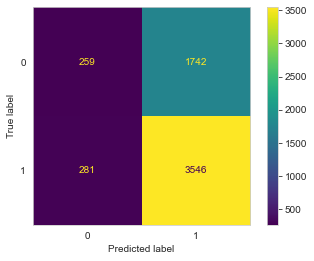

---------------Decile Analysis---------------
Top Probability: 0.5728528
Bottom Probability: 0.63683534
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6009623226014377


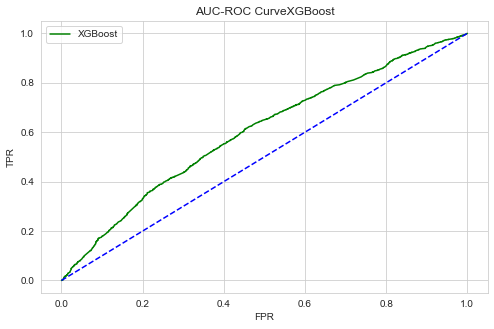

In [126]:
#Best XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_gender = xg_boost(X_train,y_gender_train,X_test,y_gender_test,**best_params_gender)
evaluation_metrics(xgb_gender,X_test,y_gender_test,"XGBoost",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - Model Stacking

#### Gender Prediction - Model Stacking - 1

---------------Model Statistics---------------
Gender Model Accuracy: 0.6568291008922443
Gender Model training Accuracy: 0.6811577622697632
Gender Model Precision: 0.6744985673352436
Gender Model Recall: 0.922654821008623
Gender Model F1 Score: 0.7792981681747959
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

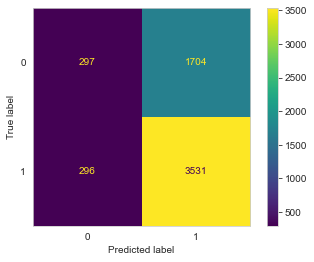

---------------Decile Analysis---------------
Top Probability: 0.5767611
Bottom Probability: 0.6321324
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6020966522226214


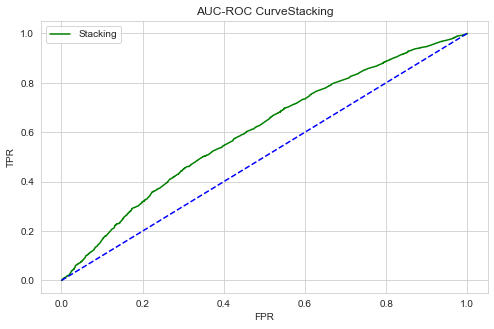

In [127]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_gender,rf_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_1=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,xgb_gender)
evaluation_metrics(stacking_gender_1,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - Model Stacking - 2

---------------Model Statistics---------------
Gender Model Accuracy: 0.6542553191489362
Gender Model training Accuracy: 0.6897380162452809
Gender Model Precision: 0.674633770239013
Gender Model Recall: 0.9145544813169585
Gender Model F1 Score: 0.776483638380477
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

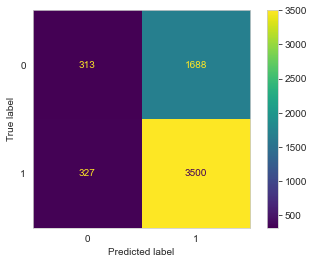

---------------Decile Analysis---------------
Top Probability: 0.5580386092446254
Bottom Probability: 0.6431805769445321
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6038932454337242


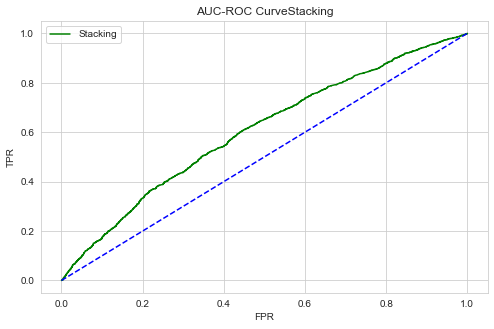

In [128]:
#### Stacking XGBoost and random forest as classifier and XGBoost as Logistic regression Meta classifier
classifiers=[xgb_gender,rf_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_2=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,lr_gender)
evaluation_metrics(stacking_gender_2,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - Model Stacking - 3

---------------Model Statistics---------------
Gender Model Accuracy: 0.6540837336993823
Gender Model training Accuracy: 0.6793273080883194
Gender Model Precision: 0.6723776889396536
Gender Model Recall: 0.9229161222889992
Gender Model F1 Score: 0.7779735682819384
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

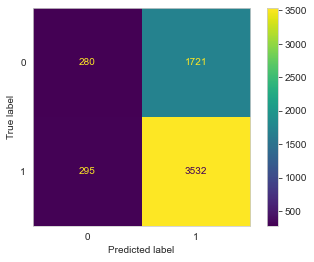

---------------Decile Analysis---------------
Top Probability: 0.5572689985884246
Bottom Probability: 0.623421389575219
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6074682804926254


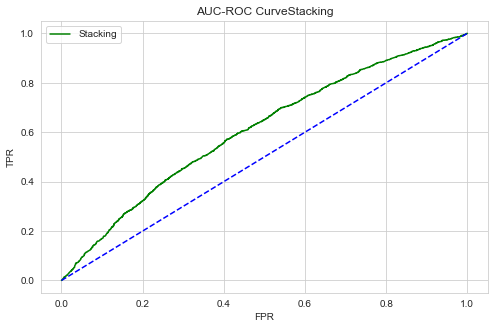

In [129]:
#### Stacking XGBoost and Logistic regression as classifier and XGBoost as Random Forest Meta classifier
classifiers=[lr_gender,xgb_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_3=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,rf_gender)
evaluation_metrics(stacking_gender_3,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

1

In [130]:
# Since Model 1 gives best accuracy, considering it is best Stacking Model
stacking_gender=stacking_gender_1

### Gender Prediction - Final Model Selection

In [131]:
# Logistic Regression Gives best accuracy so considering Logistic Regression model as final model
final_model_gender = lr_gender

## Gender Prediction - Exporting Model to a Pickle File Scenario 1

In [132]:
pickle.dump(final_model_gender,open("final_model_gender.pkl","wb"))

## Age Group Prediction

### Age Group Prediction - Data Preparation

In [133]:
dfTrain.head()

,DeviceID,Gender,AgeGroup,TravellerType,HighLevelCategory,Cluster,EventCount,MobilePhoneBrand,DeviceModel,TrainTestFlag
0,-7548291590301750000,1,2,0.693737,0.525983,0.703997,1.938428,0.687040,0.675799,train
1,6943568600617760000,1,2,0.602807,0.672893,0.602737,-0.411785,0.650285,0.616758,train
2,5441349705980020000,1,2,0.602807,0.672893,0.602737,-0.411785,0.549481,0.491018,train
3,-5393876656119450000,1,2,0.602807,0.672893,0.602737,-0.387556,0.650285,0.642433,train
4,4543988487649880000,1,3,0.737358,0.672893,0.703997,0.508917,0.637855,0.653061,train


In [134]:
#target encoding

target_columns = ['AgeGroup']

cat_columns = ["TravellerType", "HighLevelCategory", "Cluster", "MobilePhoneBrand", "DeviceModel"]
encoder = ce.TargetEncoder(cols=cat_columns)

encoder.fit(dfTrain, dfTrain["AgeGroup"])
# dfTrain.shape

dfTrain=encoder.transform(dfTrain)
dfTest=encoder.transform(dfTest)

X_train=dfTrain.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)
X_test=dfTest.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)

y_age_group_train=dfTrain["AgeGroup"]

y_age_group_test=dfTest["AgeGroup"]

### Age Group Prediction - Logistic Regression

---------------Model Statistics---------------
Age Group Model Accuracy: 0.4169526424159231
Age Group Model training Accuracy: 0.4159707127330969
Age Group Model Precision: 0.38663323370759994
Age Group Model Recall: 0.4169526424159231
Age Group Model F1 Score: 0.30725067530201844
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

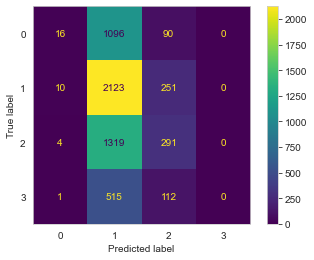

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2607


In [135]:
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_age_group_1 = logistic_regression(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(lr_age_group_1,X_test,y_age_group_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

---------------Model Statistics---------------
Age Group Model Accuracy: 0.414378860672615
Age Group Model training Accuracy: 0.41608511611943716
Age Group Model Precision: 0.279444850883026
Age Group Model Recall: 0.414378860672615
Age Group Model F1 Score: 0.29353896262283374
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

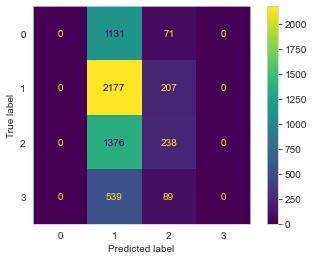

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2606


In [136]:
#Applying L1 Regularization
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_age_group_2 = logistic_regression(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",penalty='l1', solver='liblinear')
evaluation_metrics(lr_age_group_2,X_test,y_age_group_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - Logistic Model Selection

In [137]:
# Since first model gives better accuracy, making first model as final logistic regression model
lr_age_group=lr_age_group_1

### Age Group Prediction - Random Forest Classifier

---------------Model Statistics---------------
age_group Model Accuracy: 0.3466026080988332
age_group Model training Accuracy: 0.8246768104335889
age_group Model Precision: 0.32982801916936
age_group Model Recall: 0.3466026080988332
age_group Model F1 Score: 0.33632275420257857
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

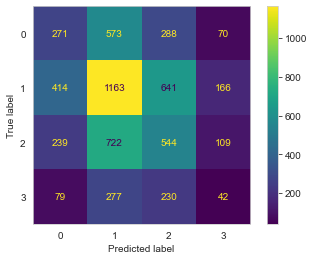

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 2.8346


In [138]:
#Base Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_age_group_1 = random_forest(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(rf_age_group_1,X_test,y_age_group_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"age_group",multiclass=True)

### Age Group Prediction - Random Forest Hyperparameter Tuning

#### Age Group Prediction - Random Forest Model 1

In [139]:
param_grid={
                "n_estimators":[120,130],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_1 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_1)

age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
Best CV Score: 0.41534148046686004
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 2

In [140]:
param_grid={
                "n_estimators":[100,120],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[80,100],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_2 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_2)

age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
Best CV Score: 0.41534148046686004
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 3

In [141]:
param_grid={
                "n_estimators":[120],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100],
               "max_depth":[50,80],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_3 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_3)

age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
Best CV Score: 0.41534148046686004
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 4

In [142]:
param_grid={
                "n_estimators":[120],
               "min_samples_split":[1,2],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100],
               "max_depth":[50,80],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_4 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_4)

age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
Best CV Score: 0.41534148046686004
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 5

In [143]:
param_grid={
                "n_estimators":[120],
               "min_samples_split":[1,2],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100],
               "max_depth":[20,50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_5 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_5)

age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
Best CV Score: 0.41534148046686004
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model Selection

In [144]:
# All Models have similar Accuracy Taking model 1 as final model
best_params_age_group=best_params_age_group_1

#### Age Group Prediction - Random Forest - Best Parameters

---------------Model Statistics---------------
age_group Model Accuracy: 0.41815374056280025
age_group Model training Accuracy: 0.44274110513671205
age_group Model Precision: 0.37245509320271114
age_group Model Recall: 0.41815374056280025
age_group Model F1 Score: 0.31931241974438135
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

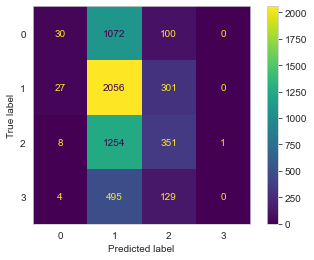

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2572


In [145]:
#Best Random Forest Model
y_pred,accuracy,training_accuracy,recall,precision,F1,rf_age_group = random_forest(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",**best_params_age_group)
evaluation_metrics(rf_age_group,X_test,y_age_group_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"age_group",multiclass=True)

### Age Group Prediction - XG Boost

---------------Model Statistics---------------
Age Group Model Accuracy: 0.39722031571722716
Age Group Model training Accuracy: 0.5584029287266903
Age Group Model Precision: 0.34907824543671423
Age Group Model Recall: 0.39722031571722716
Age Group Model F1 Score: 0.3421398201497954
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

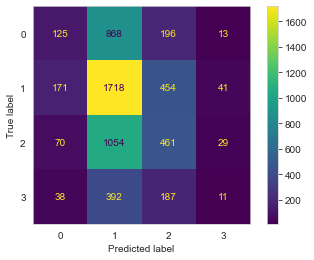

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.3112


In [146]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_age_group_1 = xg_boost(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(xgb_age_group_1,X_test,y_age_group_test,"XG Boost",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - XG Boost Hyperparameter Tuning

#### Age Group Prediction - XG Boost Model 1

In [147]:
param_grid={"n_estimators":[10,20],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_1 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_1)

age_group Model Accuracy: 0.42072752230610844
age_group Model training Accuracy: 0.42031804141402584
Best CV Score: 0.4147121276921621
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 10}


#### Age Group Prediction - XG Boost Model 2

In [148]:
param_grid={"n_estimators":[20,30],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_2 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_2)

age_group Model Accuracy: 0.4233013040494166
age_group Model training Accuracy: 0.4227205125271708
Best CV Score: 0.41419735171242106
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 20}


#### Age Group Prediction - XG Boost Model 3

In [149]:
param_grid={"n_estimators":[20],
           "max_depth":[2,4],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_3 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_3)

age_group Model Accuracy: 0.42141386410432397
age_group Model training Accuracy: 0.4211188651184075
Best CV Score: 0.4154558609510229
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 20}


#### Age Group Prediction - XG Boost Model 4

In [150]:
param_grid={"n_estimators":[10,20],
           "max_depth":[4,5],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_4 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_4)

age_group Model Accuracy: 0.4200411805078929
age_group Model training Accuracy: 0.42958471570758494
Best CV Score: 0.41396875760827023
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 10}


#### Age Group Prediction - XG Boost Model 5

In [151]:
param_grid={"n_estimators":[20,50],
           "max_depth":[4,5],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [2, 3],
            'gamma': [0.2,0.3]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_5 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_5)

age_group Model Accuracy: 0.4169526424159231
age_group Model training Accuracy: 0.4387941883079739
Best CV Score: 0.41351114733176136
Best Paramater: {'gamma': 0.2, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 50}


##### Age Group Prediction - XG Boost Tuning Model Selection

In [152]:
# Since Model 1 has best acccuracy score taking model 1 as final model
best_params_age_group=best_params_age_group_1

##### Age Group Prediction - XG Boost Model with Best Parameters

---------------Model Statistics---------------
Age Group Model Accuracy: 0.42072752230610844
Age Group Model training Accuracy: 0.42031804141402584
Age Group Model Precision: 0.4006501419116482
Age Group Model Recall: 0.42072752230610844
Age Group Model F1 Score: 0.3074688090685257
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

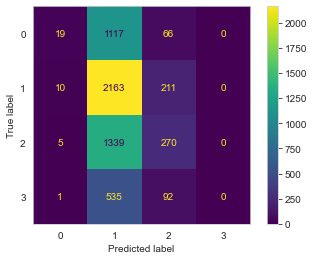

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2926


In [153]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_age_group = xg_boost(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",**best_params_age_group)
evaluation_metrics(xgb_age_group,X_test,y_age_group_test,"XG Boost",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - Model Stacking

#### Age Group Prediction - Model 1

---------------Model Statistics---------------
Age Group Model Accuracy: 0.41832532601235417
Age Group Model training Accuracy: 0.42460816840178467
Age Group Model Precision: 0.4109551316197295
Age Group Model Recall: 0.41832532601235417
Age Group Model F1 Score: 0.3156277305631045
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

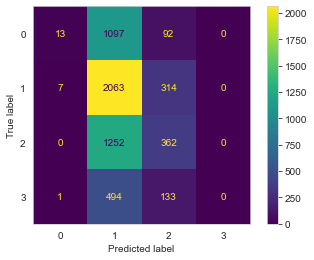

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2924


In [154]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_age_group,rf_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_1=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,xgb_age_group,average='weighted')
evaluation_metrics(stacking_age_group_1,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model 2

---------------Model Statistics---------------
Age Group Model Accuracy: 0.4188400823610158
Age Group Model training Accuracy: 0.4307287495709873
Age Group Model Precision: 0.3696330630034431
Age Group Model Recall: 0.4188400823610158
Age Group Model F1 Score: 0.3221618564474904
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

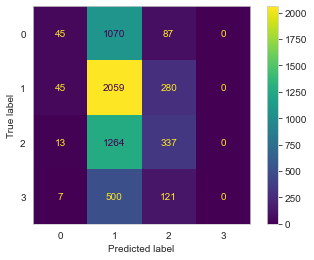

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2574


In [155]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[xgb_age_group,rf_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_2=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,lr_age_group,average='weighted')
evaluation_metrics(stacking_age_group_2,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model 3

---------------Model Statistics---------------
Age Group Model Accuracy: 0.4160947151681537
Age Group Model training Accuracy: 0.4179155703008809
Age Group Model Precision: 0.37186730819769026
Age Group Model Recall: 0.4160947151681537
Age Group Model F1 Score: 0.31579938598500706
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

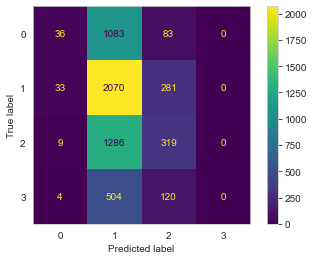

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2589


In [156]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_age_group,xgb_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_3=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,rf_age_group,average='weighted')
evaluation_metrics(stacking_age_group_3,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model Stacking - Selection

In [157]:
# Since Model 1 gives best accuracy, considering it is best Stacking Model
stacking_age_group=stacking_age_group_1

### Age Group Prediction - Final Model Selection

In [158]:
# Random Forest Gives best accuracy so considering XG Boost model as final model
final_model_age_group = xgb_age_group

## Age Group Prediction - Exporting Model to a Pickle File Scenario 1

In [159]:
pickle.dump(final_model_age_group,open("final_model_age_group.pkl","wb"))

## Scenario 2 - Devices without Events

### Data Preparation

In [160]:
dfTrainEventsWithoutEvents=dfTrainEvents.loc[dfTrainEvents["EventID"].isnull()]
print("Number of records without events :",len(dfTrainEventsWithoutEvents))

Number of records without events : 51335


In [161]:
dfTrainEventsWithoutEvents.head()

,DeviceID,Gender,Age,GroupTrain,EventID,DateTimestamp,Latitude,Longitude,Hour,WeekDay,DayName,WeekNum
1215595,398514470209561000,M,68,M32+,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1215596,-3073918292047050000,M,27,M25-32,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1215597,5805880616488060000,M,39,M32+,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1215598,-2403560729305410000,M,25,M25-32,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1215599,-1889893391998300000,M,22,M0-24,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
dfDeviceWithoutEvents = dfTrainEventsWithoutEvents[["DeviceID", "Gender", "Age"]].drop_duplicates(subset=None, keep="first")
dfDeviceWithoutEvents.shape

(51335, 3)

In [163]:
dfDeviceWithoutEventsMerged = pd.merge(dfDeviceWithoutEvents, dfMobileBrand, how="left", on="DeviceID")
print(dfDeviceWithoutEventsMerged.shape)

(51335, 5)


In [164]:
dfDeviceWithoutEventsMerged.head()

,DeviceID,Gender,Age,MobilePhoneBrand,DeviceModel
0,398514470209561000,M,68,HUAWEI,4X
1,-3073918292047050000,M,27,HUAWEI,4C
2,5805880616488060000,M,39,LSHI,1
3,-2403560729305410000,M,25,NIBILU,
4,-1889893391998300000,M,22,HUAWEI,3X


In [165]:
dfDeviceWithoutEventsMerged["AgeGroup"] = dfDeviceWithoutEventsMerged.Age.map(ageGroup)

dfDeviceWithoutEventsMerged.head()

,DeviceID,Gender,Age,MobilePhoneBrand,DeviceModel,AgeGroup
0,398514470209561000,M,68,HUAWEI,4X,46+
1,-3073918292047050000,M,27,HUAWEI,4C,25-32
2,5805880616488060000,M,39,LSHI,1,33-45
3,-2403560729305410000,M,25,NIBILU,,25-32
4,-1889893391998300000,M,22,HUAWEI,3X,0-24


### Label Encoding

In [166]:
#Defining Target Columns
target_columns = ['Gender', 'AgeGroup']

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Apply label encoding on the selected columns
dfDeviceWithoutEventsMergedEncoded = dfDeviceWithoutEventsMerged.copy()
label_mappings = {}

for column in target_columns:
    encoded_labels = encoder.fit_transform(dfDeviceWithoutEventsMerged[column])
    dfDeviceWithoutEventsMergedEncoded[column] = encoded_labels
    label_mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mappings for each column
for column, mappings in label_mappings.items():
    print(f"Label Mappings for column '{column}':")
    for label, encoded_label in mappings.items():
        print(f"{label} : {encoded_label}")
    print()

Label Mappings for column 'Gender':
F : 0
M : 1

Label Mappings for column 'AgeGroup':
0-24 : 0
25-32 : 1
33-45 : 2
46+ : 3



### Train Test Split

In [167]:
dfTrainTest = pd.read_csv("train_test_split.csv")

dfTrainTest.columns = ["DeviceID", "Gender", "Age", "Group", "TrainTestFlag"]
dfTrainTest.head()

,DeviceID,Gender,Age,Group,TrainTestFlag
0,-7548291590301750000,M,33,M32+,train
1,6943568600617760000,M,37,M32+,train
2,5441349705980020000,M,40,M32+,train
3,-5393876656119450000,M,33,M32+,train
4,4543988487649880000,M,53,M32+,train


In [168]:
dfDeviceWithoutEventsMergedTraintest=pd.merge(dfDeviceWithoutEventsMergedEncoded,dfTrainTest[["DeviceID","TrainTestFlag"]],how="inner",on="DeviceID")
df_train=dfDeviceWithoutEventsMergedTraintest[dfDeviceWithoutEventsMergedTraintest["TrainTestFlag"]=="train"]
df_test=dfDeviceWithoutEventsMergedTraintest[dfDeviceWithoutEventsMergedTraintest["TrainTestFlag"]=="test"]

### Target Encoder for Gender Prediction

In [169]:

target_columns = ['Gender']

cat_columns = ["MobilePhoneBrand", "DeviceModel"]
encoder = ce.TargetEncoder(cols=cat_columns)

encoder.fit(dfTrain, dfTrain["Gender"])
# train_df.shape


dfTrain=encoder.transform(dfTrain)
dfTest=encoder.transform(dfTest)

In [170]:
X_train=dfTrain.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)
X_test=dfTest.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)

y_gender_train=dfTrain["Gender"]
y_gender_test=dfTest["Gender"]

## Gender Prediction

### Gender Prediction - Logistic Regression

In [171]:
X_train.head()

,TravellerType,HighLevelCategory,Cluster,EventCount,MobilePhoneBrand,DeviceModel
0,1.274235,1.219803,1.271405,1.938428,0.687040,0.675799
1,1.296842,1.286184,1.296807,-0.411785,0.650285,0.616758
2,1.296842,1.286184,1.296807,-0.411785,0.549481,0.491018
3,1.296842,1.286184,1.296807,-0.387556,0.650285,0.642433
4,1.317853,1.286184,1.271405,0.508917,0.637855,0.653061


---------------Model Statistics---------------
Gender Model Accuracy: 0.6463623884694578
Gender Model training Accuracy: 0.6703466422606109
Gender Model Precision: 0.6669187145557656
Gender Model Recall: 0.9218709171674941
Gender Model F1 Score: 0.773938795656466
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

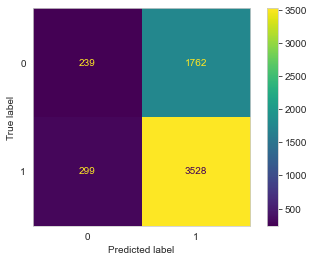

---------------Decile Analysis---------------
Top Probability: 0.576112057844596
Bottom Probability: 0.6406484901255407
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5731044198308477


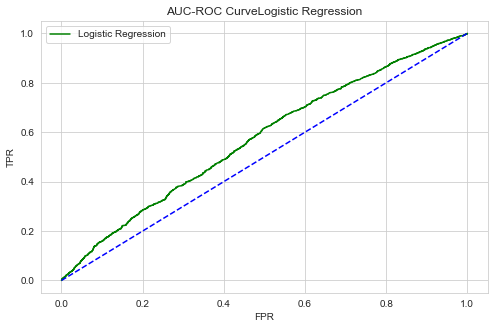

In [172]:
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_gender_1 = logistic_regression(X_train,y_gender_train,X_test,y_gender_test)
evaluation_metrics(lr_gender_1,X_test,y_gender_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Gender")

---------------Model Statistics---------------
Gender Model Accuracy: 0.6455044612216884
Gender Model training Accuracy: 0.6706326507264615
Gender Model Precision: 0.666729786025374
Gender Model Recall: 0.9200418082048603
Gender Model F1 Score: 0.7731664470794906
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

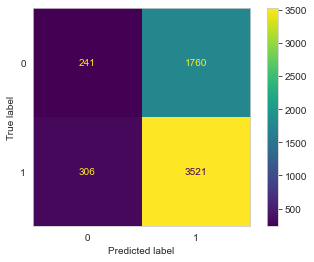

---------------Decile Analysis---------------
Top Probability: 0.5744167264928394
Bottom Probability: 0.640628816314427
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5722433400493379


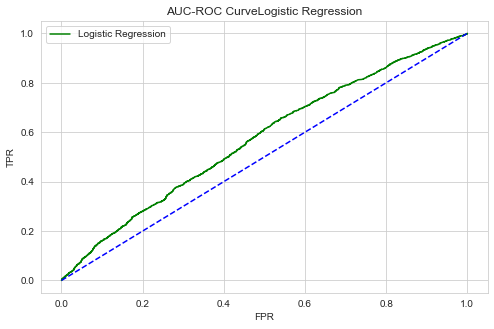

In [173]:
#Applying L1 Regularization
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_gender_2 = logistic_regression(X_train,y_gender_train,X_test,y_gender_test,penalty='l1', solver='liblinear')
evaluation_metrics(lr_gender_2,X_test,y_gender_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - Logistic Model Selection

In [174]:
# Since first model gives better accuracy, making first model as final logistic regression model
lr_gender=lr_gender_1

### Gender Prediction - Random Forest Classifier

---------------Model Statistics---------------
Gender Model Accuracy: 0.5887096774193549
Gender Model training Accuracy: 0.8913167829767761
Gender Model Precision: 0.6726219217769194
Gender Model Recall: 0.727985367128299
Gender Model F1 Score: 0.699209436566696
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

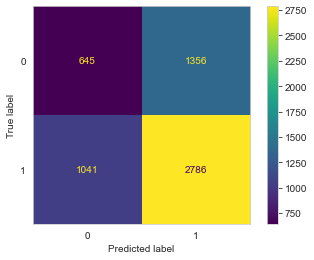

---------------Decile Analysis---------------
Top Probability: 0.4
Bottom Probability: 0.6
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.545694098338863


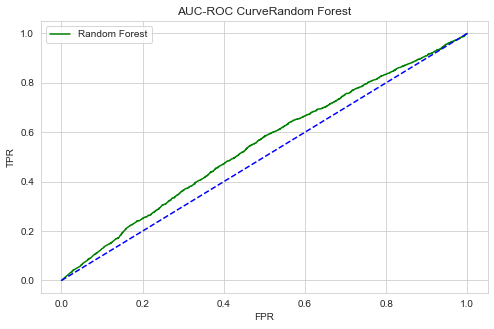

In [175]:
#Base Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_gender_1 = random_forest(X_train,y_gender_train,X_test,y_gender_test)
evaluation_metrics(rf_gender_1,X_test,y_gender_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - Random Forest Hyperparameter Tuning

#### Gender Prediction - Random Forest - Model 1

In [176]:
param_grid={
                "n_estimators":[120,130],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_1 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_1)

Gender Model Accuracy: 0.6527110501029513
Gender Model training Accuracy: 0.689795217938451
Best CV Score: 0.6736071366354929
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 2

In [177]:
param_grid={
                "n_estimators":[100,120],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[120,130],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_2 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_2)

Gender Model Accuracy: 0.6525394646533974
Gender Model training Accuracy: 0.6919116805857454
Best CV Score: 0.6734354922927008
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 120, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Gender Prediction - Random Forest - Model 3

In [178]:
param_grid={
                "n_estimators":[120],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[130],
               "max_depth":[20,50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_3 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,rf_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_3)

Gender Model Accuracy: 0.6523678792038435
Gender Model training Accuracy: 0.6925408992106167
Best CV Score: 0.6726918866358561
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 130, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Gender Prediction - Random Forest - Model Selection

In [179]:
# Since Model 2 has best acccuracy score taking model 2 as final model
best_params_gender=best_params_gender_2

#### Gender Prediction - Random Forest - Best Parameters

---------------Model Statistics---------------
Gender Model Accuracy: 0.6525394646533974
Gender Model training Accuracy: 0.6919116805857454
Gender Model Precision: 0.6711626139817629
Gender Model Recall: 0.9231774235693755
Gender Model F1 Score: 0.7772522274777252
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

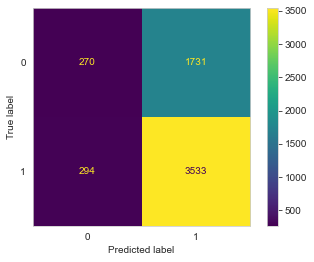

---------------Decile Analysis---------------
Top Probability: 0.5628700872338512
Bottom Probability: 0.6328673492941205
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.6009296109718854


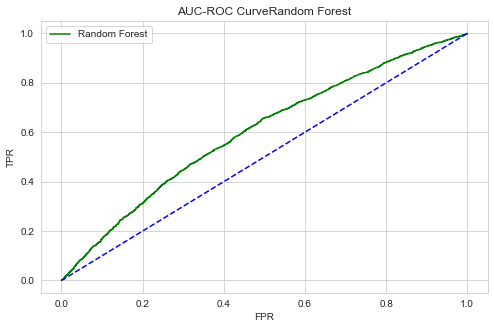

In [180]:
#Best Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_gender = random_forest(X_train,y_gender_train,X_test,y_gender_test,**best_params_gender)
evaluation_metrics(rf_gender,X_test,y_gender_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - XG Boost

---------------Model Statistics---------------
Gender Model Accuracy: 0.6372683596431022
Gender Model training Accuracy: 0.7279487472829196
Gender Model Precision: 0.6708557749850389
Gender Model Recall: 0.8787562059054089
Gender Model F1 Score: 0.7608597285067874
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

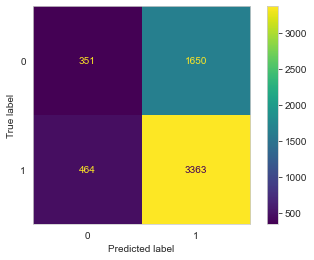

---------------Decile Analysis---------------
Top Probability: 0.5423809
Bottom Probability: 0.62105054
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5780063326058423


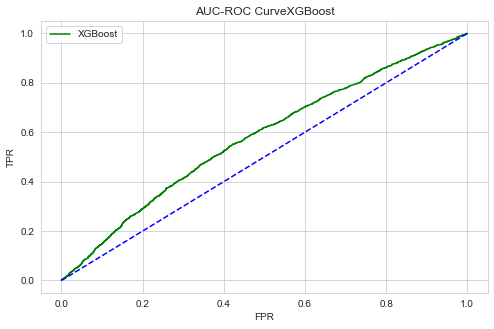

In [181]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_gender_1 = xg_boost(X_train,y_gender_train,X_test,y_gender_test)
evaluation_metrics(xgb_gender_1,X_test,y_gender_test,"XGBoost",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - XG Boost Hyperparameter Tuning

##### Gender Prediction - XG Boost Tuning Model 1

In [182]:
param_grid={"n_estimators":[10,20],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_1 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_1)

Gender Model Accuracy: 0.6561427590940289
Gender Model training Accuracy: 0.6777828623727262
Best CV Score: 0.6739504253210771
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20}


##### Gender Prediction - XG Boost Tuning Model 2

In [183]:
param_grid={"n_estimators":[10,20],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [3,5],
            'gamma': [0.1, 0.2]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_2 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_2)

Gender Model Accuracy: 0.6549416609471517
Gender Model training Accuracy: 0.6775540556000458
Best CV Score: 0.6745224847905268
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 20}


##### Gender Prediction - XG Boost Tuning Model 3

In [184]:
param_grid={"n_estimators":[20],
           "max_depth":[6,8],
           "learning_rate":[0.3,0.4],
            'min_child_weight': [2, 3],
            'gamma': [0.2, 0.3]
            
           }

y_gender_pred,accuracy_gender,training_accuracy_gender,cv_gender,best_score_gender,best_params_gender_3 = cross_validation(X_train,y_gender_train,X_test,y_gender_test,xgb_gender_1,param_grid)
print("Gender Model Accuracy:",accuracy_gender)
print("Gender Model training Accuracy:",training_accuracy_gender)
print("Best CV Score:",best_score_gender)
print("Best Paramater:",best_params_gender_3)

Gender Model Accuracy: 0.6533973919011667
Gender Model training Accuracy: 0.6885367806887084
Best CV Score: 0.6711474114635374
Best Paramater: {'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 20}


##### Gender Prediction - XG Boost Tuning Model Selection

In [185]:
# Since Model 3 has best acccuracy score taking model 3 as final model
best_params_gender=best_params_gender_3

##### Gender Prediction - XG Boost Model with Best Parameters

---------------Model Statistics---------------
Gender Model Accuracy: 0.6533973919011667
Gender Model training Accuracy: 0.6885367806887084
Gender Model Precision: 0.6725883476599809
Gender Model Recall: 0.9200418082048603
Gender Model F1 Score: 0.7770911498565438
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

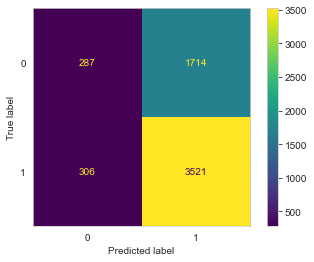

---------------Decile Analysis---------------
Top Probability: 0.5570441
Bottom Probability: 0.6298447
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5942144553539797


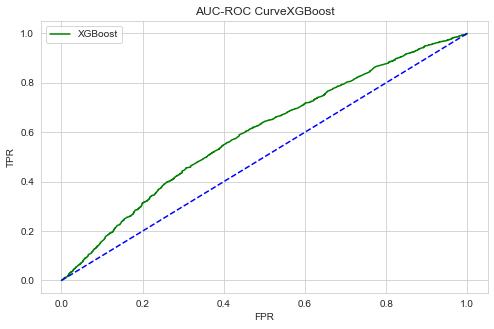

In [186]:
#Best XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_gender = xg_boost(X_train,y_gender_train,X_test,y_gender_test,**best_params_gender)
evaluation_metrics(xgb_gender,X_test,y_gender_test,"XGBoost",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - Model Stacking

#### Gender Prediction - Model Stacking - 1

---------------Model Statistics---------------
Gender Model Accuracy: 0.6499656829100893
Gender Model training Accuracy: 0.6868207298936049
Gender Model Precision: 0.6715300441543482
Gender Model Recall: 0.914031878756206
Gender Model F1 Score: 0.7742363877822046
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

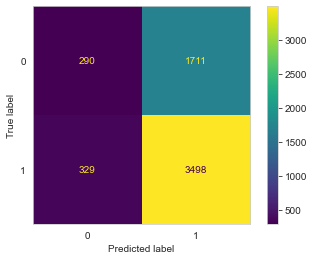

---------------Decile Analysis---------------
Top Probability: 0.56564224
Bottom Probability: 0.6280575
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5952578975732933


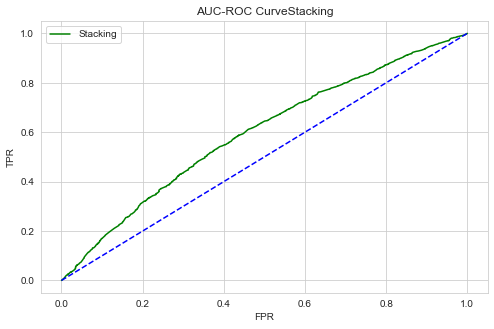

In [187]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_gender,rf_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_1=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,xgb_gender)
evaluation_metrics(stacking_gender_1,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - Model Stacking - 2

---------------Model Statistics---------------
Gender Model Accuracy: 0.6532258064516129
Gender Model training Accuracy: 0.6916256721198948
Gender Model Precision: 0.6739884393063584
Gender Model Recall: 0.914031878756206
Gender Model F1 Score: 0.7758678052567373
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

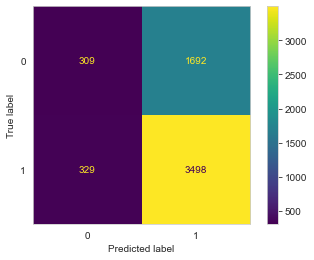

---------------Decile Analysis---------------
Top Probability: 0.5604411613468734
Bottom Probability: 0.6388665546802724
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.598494781874806


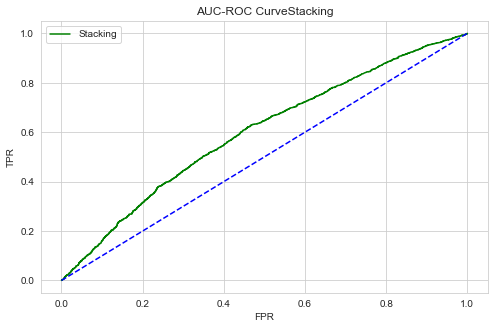

In [188]:
#### Stacking XGBoost and random forest as classifier and XGBoost as Logistic regression Meta classifier
classifiers=[xgb_gender,rf_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_2=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,lr_gender)
evaluation_metrics(stacking_gender_2,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

#### Gender Prediction - Model Stacking - 3

---------------Model Statistics---------------
Gender Model Accuracy: 0.6467055593685656
Gender Model training Accuracy: 0.6810433588834229
Gender Model Precision: 0.6702619414483821
Gender Model Recall: 0.909328455709433
Gender Model F1 Score: 0.7717041800643086
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

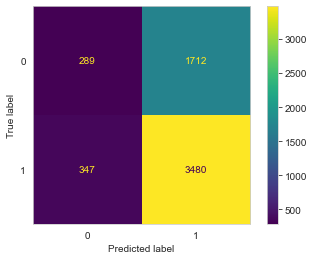

---------------Decile Analysis---------------
Top Probability: 0.5664555189343126
Bottom Probability: 0.6274244669243565
KS Statistic
Decile 0: 0.0006009929448654305
Decile 1: 0.000888424353279349
Decile 2: 0.005252155735563091
Decile 3: 5.226025607524276e-05
Decile 4: 0.0027436634439508834
Decile 5: 0.0029265743402142608
Decile 6: 0.0020642801149725054
Decile 7: 0.0048602038149987425
Decile 8: 0.0026914031878756406
Decile 9: 0.0010452051215050773
---------------ROC Curve---------------
ROC AUC SCORE ->  0.5907709850326992


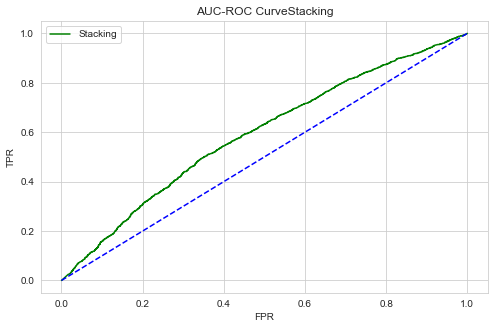

In [189]:
#### Stacking XGBoost and Logistic regression as classifier and XGBoost as Random Forest Meta classifier
classifiers=[lr_gender,xgb_gender]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_gender_3=model_stacking(X_train,y_gender_train,X_test,y_gender_test,classifiers,rf_gender)
evaluation_metrics(stacking_gender_3,X_test,y_gender_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Gender")

### Gender Prediction - Final Model Selection

In [190]:
# Since Model 3 gives best accuracy, considering it is best Stacking Model
stacking_gender=stacking_gender_3

## Gender Prediction - Exporting Model to a Pickle File Scenario 2

In [191]:
# Stacking Model Gives best accuracy so considering Stacking model as final model
final_model_gender = stacking_gender

## Age Group Prediction

### Age Group Prediction - train test Split

In [193]:
#target encoding

target_columns = ['AgeGroup']

cat_columns = ["MobilePhoneBrand", "DeviceModel"]
encoder = ce.TargetEncoder(cols=cat_columns)

encoder.fit(dfTrain, dfTrain["AgeGroup"])
# train_df.shape


dfTrain=encoder.transform(dfTrain)
dfTest=encoder.transform(dfTest)

X_train=dfTrain.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)
X_test=dfTest.drop(["AgeGroup","Gender","DeviceID","TrainTestFlag"],axis=1)

y_age_group_train=dfTrain["AgeGroup"]

y_age_group_test=dfTest["AgeGroup"]

### Age Group Prediction - Logistic Regression

---------------Model Statistics---------------
Age Group Model Accuracy: 0.4155799588194921
Age Group Model training Accuracy: 0.41551309918773593
Age Group Model Precision: 0.36902615023219154
Age Group Model Recall: 0.4155799588194921
Age Group Model F1 Score: 0.3060552700720983
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

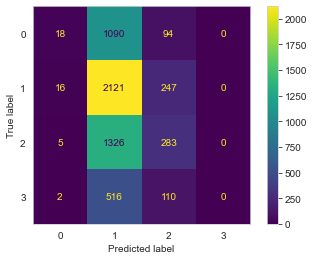

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2609


In [194]:
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_age_group_1 = logistic_regression(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(lr_age_group_1,X_test,y_age_group_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

---------------Model Statistics---------------
Age Group Model Accuracy: 0.4140356897735072
Age Group Model training Accuracy: 0.41614231781260724
Age Group Model Precision: 0.2783214562802894
Age Group Model Recall: 0.4140356897735072
Age Group Model F1 Score: 0.2924301535196202
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

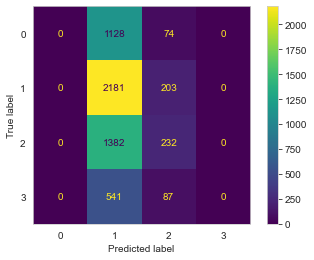

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2607


In [195]:
#Applying L1 Regularization
y_pred,accuracy,training_accuracy,recall,precision,F1,lr_age_group_2 = logistic_regression(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",penalty='l1', solver='liblinear')
evaluation_metrics(lr_age_group_2,X_test,y_age_group_test,"Logistic Regression",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - Logistic Model Selection


In [196]:
# Since first model gives better accuracy, making first model as final logistic regression model
lr_age_group=lr_age_group_1

### Age Group Prediction - Random Forest Classifier

---------------Model Statistics---------------
age_group Model Accuracy: 0.3495195607412491
age_group Model training Accuracy: 0.8242191968882279
age_group Model Precision: 0.3330618311130203
age_group Model Recall: 0.3495195607412491
age_group Model F1 Score: 0.3394233217800657
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

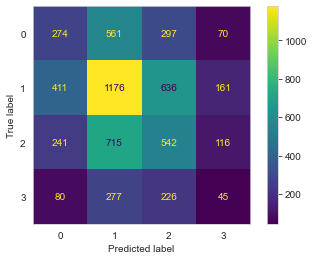

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 2.8767


In [197]:
#Base Random Forest Model

y_pred,accuracy,training_accuracy,recall,precision,F1,rf_age_group_1 = random_forest(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(rf_age_group_1,X_test,y_age_group_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"age_group",multiclass=True)

### Age Group Prediction - Random Forest Hyperparameter Tuning


#### Age Group Prediction - Random Forest Model 1

In [198]:
param_grid={
                "n_estimators":[120,130],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100,120],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_1 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_1)

age_group Model Accuracy: 0.4172958133150309
age_group Model training Accuracy: 0.4485756778400641
Best CV Score: 0.4151699637260841
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 120, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 120, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 2


In [199]:
param_grid={
                "n_estimators":[130,140],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[80,100],
               "max_depth":[50],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_2 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_2)

age_group Model Accuracy: 0.42072752230610844
age_group Model training Accuracy: 0.4390801967738245
Best CV Score: 0.4155131837028903
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 80, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 140, 'oob_score': True}


#### Age Group Prediction - Random Forest Model 3

In [200]:
param_grid={
                "n_estimators":[130],
               "min_samples_split":[2,3],
               "min_samples_leaf":[3,5],
               "max_leaf_nodes":[100],
               "max_depth":[50,80],
               "oob_score":[True],
                "bootstrap":[True]

               }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_3 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,rf_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_3)

age_group Model Accuracy: 0.4178105696636925
age_group Model training Accuracy: 0.4434847271479236
Best CV Score: 0.41454068947570377
Best Paramater: {'bootstrap': True, 'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 130, 'oob_score': True}


#### Age Group Prediction - Random Forest Model Selection

In [201]:
# Since Model 1 has best acccuracy score taking model 1 as final model
best_params_age_group=best_params_age_group_1

#### Age Group Prediction - Random Forest - Best Parameters

---------------Model Statistics---------------
age_group Model Accuracy: 0.4172958133150309
age_group Model training Accuracy: 0.4485756778400641
age_group Model Precision: 0.3699717387329269
age_group Model Recall: 0.4172958133150309
age_group Model F1 Score: 0.31974818891482343
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

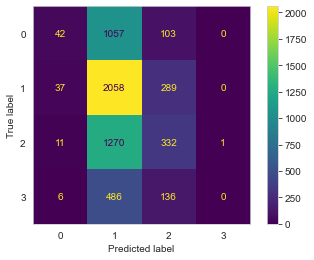

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2576


In [202]:
#Best Random Forest Model
y_pred,accuracy,training_accuracy,recall,precision,F1,rf_age_group = random_forest(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",**best_params_age_group)
evaluation_metrics(rf_age_group,X_test,y_age_group_test,"Random Forest",accuracy,training_accuracy,recall,precision,F1,"age_group",multiclass=True)

### Age Group Prediction - XG Boost


---------------Model Statistics---------------
Age Group Model Accuracy: 0.3953328757721345
Age Group Model training Accuracy: 0.5620638370895779
Age Group Model Precision: 0.35200531097511084
Age Group Model Recall: 0.3953328757721345
Age Group Model F1 Score: 0.341999539591764
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

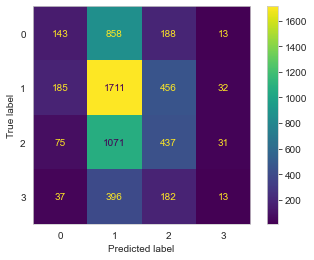

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.3112


In [203]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_age_group_1 = xg_boost(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted")
evaluation_metrics(xgb_age_group_1,X_test,y_age_group_test,"XG Boost",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - XG Boost Hyperparameter Tuning

#### Age Group Prediction - XG Boost Model 1

In [204]:
param_grid={"n_estimators":[10,20],
           "max_depth":[3,6],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_1 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_1)

age_group Model Accuracy: 0.42312971859986276
age_group Model training Accuracy: 0.42134767189108796
Best CV Score: 0.4133966196145029
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20}


#### Age Group Prediction - XG Boost Model 2


In [205]:
param_grid={"n_estimators":[10,20],
           "max_depth":[6,9],
           "learning_rate":[0.3,0.5],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_1 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_1)

age_group Model Accuracy: 0.41506520247083045
age_group Model training Accuracy: 0.45109255233954926
Best CV Score: 0.41133771200633285
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 10}


#### Age Group Prediction - XG Boost Model 3

In [206]:
param_grid={"n_estimators":[20],
           "max_depth":[2,4],
           "learning_rate":[0.1,0.3],
            'min_child_weight': [2, 3],
            'gamma': [0.1, 0.2]
            
           }

y_age_group_pred,accuracy_age_group,training_accuracy_age_group,cv_age_group,best_score_age_group,best_params_age_group_3 = cross_validation(X_train,y_age_group_train,X_test,y_age_group_test,xgb_age_group_1,param_grid)
print("age_group Model Accuracy:",accuracy_age_group)
print("age_group Model training Accuracy:",training_accuracy_age_group)
print("Best CV Score:",best_score_age_group)
print("Best Paramater:",best_params_age_group_3)

age_group Model Accuracy: 0.4174673987645848
age_group Model training Accuracy: 0.41648552797162797
Best CV Score: 0.41276731591750343
Best Paramater: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 20}


##### Age Group Prediction - XG Boost Tuning Model Selection


In [207]:
# Since Model 2 has best acccuracy score taking model 2 as final model
best_params_age_group=best_params_age_group_2

##### Age Group Prediction - XG Boost Model with Best Parameters

---------------Model Statistics---------------
Age Group Model Accuracy: 0.3452299245024022
Age Group Model training Accuracy: 0.814552110742478
Age Group Model Precision: 0.3298950095838895
Age Group Model Recall: 0.3452299245024022
Age Group Model F1 Score: 0.33590656556453374
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

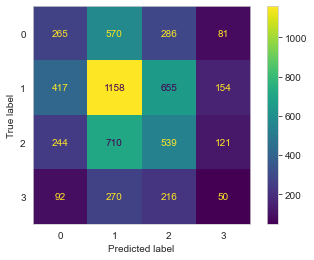

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 2.2651


In [208]:
#Base XG Boost Model

y_pred,accuracy,training_accuracy,recall,precision,F1,xgb_age_group = xg_boost(X_train,y_age_group_train,X_test,y_age_group_test,average="weighted",**best_params_age_group)
evaluation_metrics(xgb_age_group,X_test,y_age_group_test,"XG Boost",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

### Age Group Prediction - Model Stacking


#### Age Group Prediction - Model 1


---------------Model Statistics---------------
Age Group Model Accuracy: 0.363761153054221
Age Group Model training Accuracy: 0.38216451206955726
Age Group Model Precision: 0.32991969004763066
Age Group Model Recall: 0.363761153054221
Age Group Model F1 Score: 0.3371592986592991
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

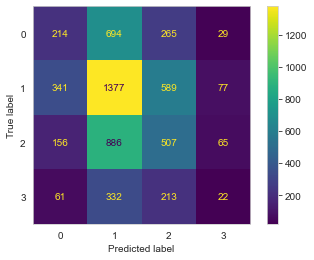

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.8127


In [209]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_age_group,rf_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_1=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,xgb_age_group,average='weighted')
evaluation_metrics(stacking_age_group_1,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model 2


---------------Model Statistics---------------
Age Group Model Accuracy: 0.4166094715168154
Age Group Model training Accuracy: 0.41482667886969454
Age Group Model Precision: 0.3708195123220239
Age Group Model Recall: 0.4166094715168154
Age Group Model F1 Score: 0.3208007591382991
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

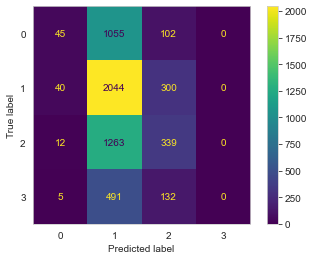

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2580


In [210]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[xgb_age_group,rf_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_2=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,lr_age_group,average='weighted')
evaluation_metrics(stacking_age_group_2,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model 3


---------------Model Statistics---------------
Age Group Model Accuracy: 0.414378860672615
Age Group Model training Accuracy: 0.42706784120809976
Age Group Model Precision: 0.357189127633787
Age Group Model Recall: 0.414378860672615
Age Group Model F1 Score: 0.31797426342269003
---------------Confusion Matrix---------------


<Figure size 576x360 with 0 Axes>

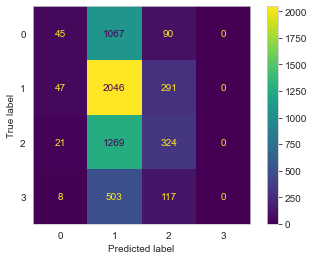

---------------Multiclass Log Loss---------------
Multiclass Log Loss: 1.2623


In [211]:
#### Stacking Logistic regression and random forest as classifier and XGBoost as Meta classifier
classifiers=[lr_age_group,xgb_age_group]
y_pred,accuracy,training_accuracy,recall,precision,F1,stacking_age_group_3=model_stacking(X_train,y_age_group_train,X_test,y_age_group_test,classifiers,rf_age_group,average='weighted')
evaluation_metrics(stacking_age_group_3,X_test,y_age_group_test,"Stacking",accuracy,training_accuracy,recall,precision,F1,"Age Group",multiclass=True)

#### Age Group Prediction - Model Stacking - Selection


In [212]:
# Since Model 2 gives best accuracy, considering it is best Stacking Model
stacking_age_group=stacking_age_group_2

### Age Group Prediction - Final Model Selection


In [213]:
# Stacking Gives best accuracy so considering Stacking model as final model
final_model_age_group = stacking_age_group

# End of the Assignment
# Thank You!
## praveenselvaraj.ps@gmail.com
## praveenselvaraj@arizona.edu